In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

from etl.util import prepare_dataset_without_leakage
from ml_features.features import prepare_features
from ml_features.customer_features import create_customer_features
from ml_features.sequence_features  import create_sequence_features
from ml_features.brand_features import create_brand_features
from ml_features.model_features import create_model_features
from ml_features.market_features import create_market_features
from ml_features.equipment_features import create_equipment_features
from ml_features.solution_complexity_features import create_solution_complexity_features
from ml_features.timeline_features import create_timeline_features, create_advanced_timeline_features, create_timeline_interaction_features
from ml_features.role_features import create_commercial_role_features
from ml_features.process_features import create_process_features
from ml_features.correction_features import create_correction_features
from ml_training.train_rf import train_rf
from ml_evaluation.dashboard import model_evaluation_report

import warnings
warnings.filterwarnings('ignore')

# Load original clean quote data
df_quotes = pd.read_csv('cleaned_quote_data.csv')
df_quotes['dt_creation_devis'] = pd.to_datetime(df_quotes['dt_creation_devis'])
df_quotes.columns


Index(['id_devis', 'num_devis', 'nom_devis', 'nom_agence', 'nom_filiale_zone',
       'nom_region', 'statut_devis', 'fg_devis_emis', 'fg_devis_refuse',
       'fg_devis_accepte', 'dt_creation_devis', 'dt_signature_devis',
       'fg_3_mois_mature', 'type_devis', 'mt_apres_remise_ht_devis',
       'mt_marge', 'nb_devis_emis', 'mt_apres_remise_ht_emis_devis',
       'mt_marge_emis_devis', 'mt_remise_exceptionnelle_ht',
       'mt_ttc_apres_aide_devis', 'mt_ttc_avant_aide_devis', 'mt_prime_cee',
       'mt_prime_maprimerenov', 'fg_activite_commerciale',
       'prenom_nom_createur', 'prenom_nom_commercial', 'nom_campagne',
       'famille_equipement_produit', 'type_equipement_produit',
       'dth_emission_devis', 'dt_emission_calcule_devis', 'id_opportunite',
       'fg_devis_principal', 'lb_statut_preparation_chantier', 'numero_compte',
       'dt_visite_commerciale', 'fonction_commercial',
       'regroup_famille_equipement_produit', 'marque_produit',
       'modele_produit', 'dt_factu

In [2]:
print(f"\n📊 Original quote data: {len(df_quotes):,} quotes from {df_quotes['numero_compte'].nunique():,} customers")


print("\n" + "="*80)
print("STRATEGY: CREATE MEANINGFUL SEQUENCE FEATURES")
print("="*80)

# 1. Enhanced customer features
customer_df = create_customer_features(df_quotes)
print(len(customer_df))

# 2. Sequence features (for multi-quote customers)
sequence_df = create_sequence_features(df_quotes)
print(len(sequence_df))


📊 Original quote data: 34,014 quotes from 23,888 customers

STRATEGY: CREATE MEANINGFUL SEQUENCE FEATURES
Creating OPTIMIZED customer features (mode: first_conversion)...
  Filtering post-first-purchase data...
  Customers: 23,888, Quotes: 33,247
  Calculating features...
  Calculating price trajectory (optimized)...
✓ Created 14 leakage-free features
→ 23,888 customers | 39.6% converters
⏱️  Execution time: 9.9 seconds
⚠️  9.9s (target was 3s)
23888
CREATING FIRST CONVERSION PREDICTION FEATURES (LEAKAGE-FREE)
  Total customers: 23,888
⚡ Processing customers with corrected first-conversion logic...
  Processed 0/23,888 customers
  Processed 5,000/23,888 customers
  Processed 10,000/23,888 customers
  Processed 15,000/23,888 customers
  Processed 20,000/23,888 customers
✅ First-conversion features calculation complete

🔍 VALIDATION REPORT:
   Total customers: 23,888
   First converters: 9,458 (39.6%)
   Never converters: 14,430

📊 Distribution check:
   Converters with 0 historical quo

CREATING BRAND FEATURES (ULTRA-FAST, LEAKAGE-FREE)
Processing 34,014 quotes for 23,888 customers
👥 Single groupby aggregation...
  Processing 23,888 customers with brand data
⚡ Vectorized feature calculation...
✅ Vectorized calculations complete
📝 Creating final DataFrame...

✅ Created 8 brand features
   Total customers: 23,888
   With brand data: 23,888

📊 FEATURE SUMMARY:
--------------------------------------------------
brand_loyalty_index       : mean = 0.923
brand_switches            : mean = 0.186
brand_consistency         : mean = 0.840
prefers_premium_brand     : mean = 0.240
prefers_budget_brand      : mean = 0.313
CREATING MODEL FEATURES (HYPER-FAST)
Processing 23,888 customers
👥 Grouping and preprocessing...
  Processing 23,888 customers
⚡ Hyper-fast calculations...
✅ Calculations complete
📝 Creating final DataFrame...

✅ Created 14 model features
   Customers: 23,888
23888
CREATING LEAKAGE-FREE MARKET FEATURES
🚨 FORCE REMOVING LEAKY BRANDS
Found 23 leaky brands
Found 23 n

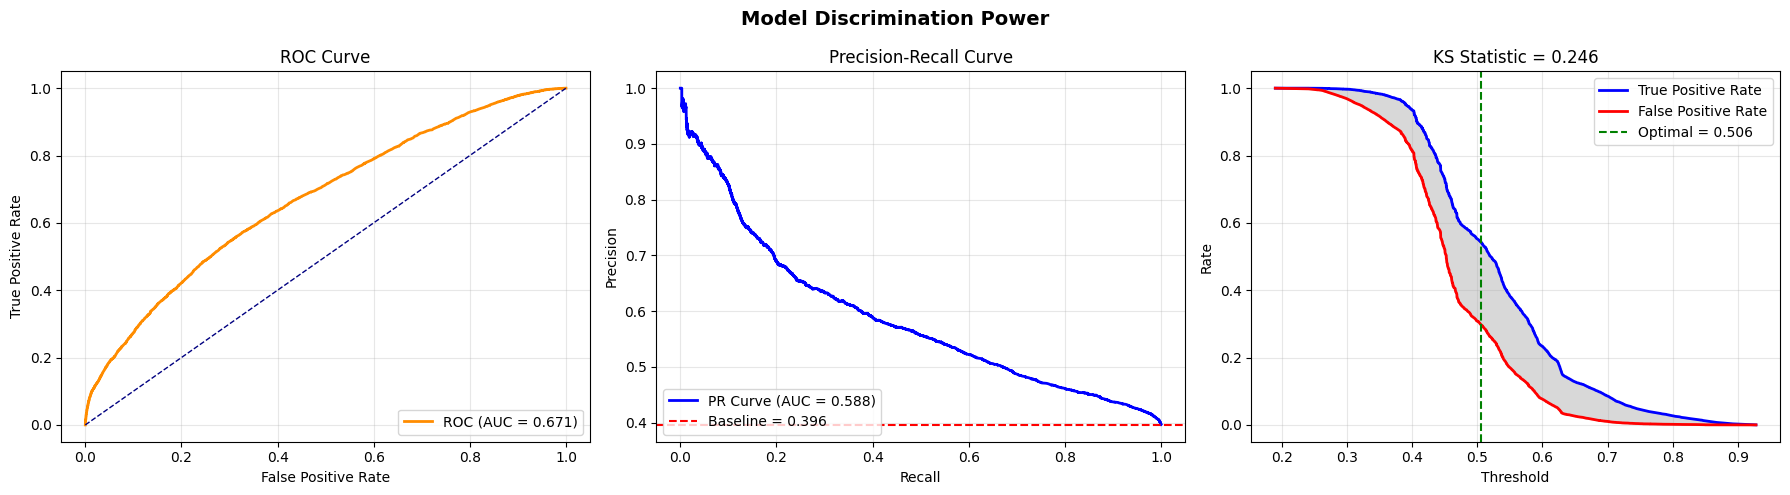

• ROC-AUC: 0.6705
• PR-AUC: 0.5875
• KS Statistic: 0.246 (WEAK discrimination)
• Optimal Threshold: 0.506

💼 STEP 2: BUSINESS IMPACT
----------------------------------------
Verification of decile assignment:
Decile 1 mean prob: 0.699
Decile 10 mean prob: 0.334


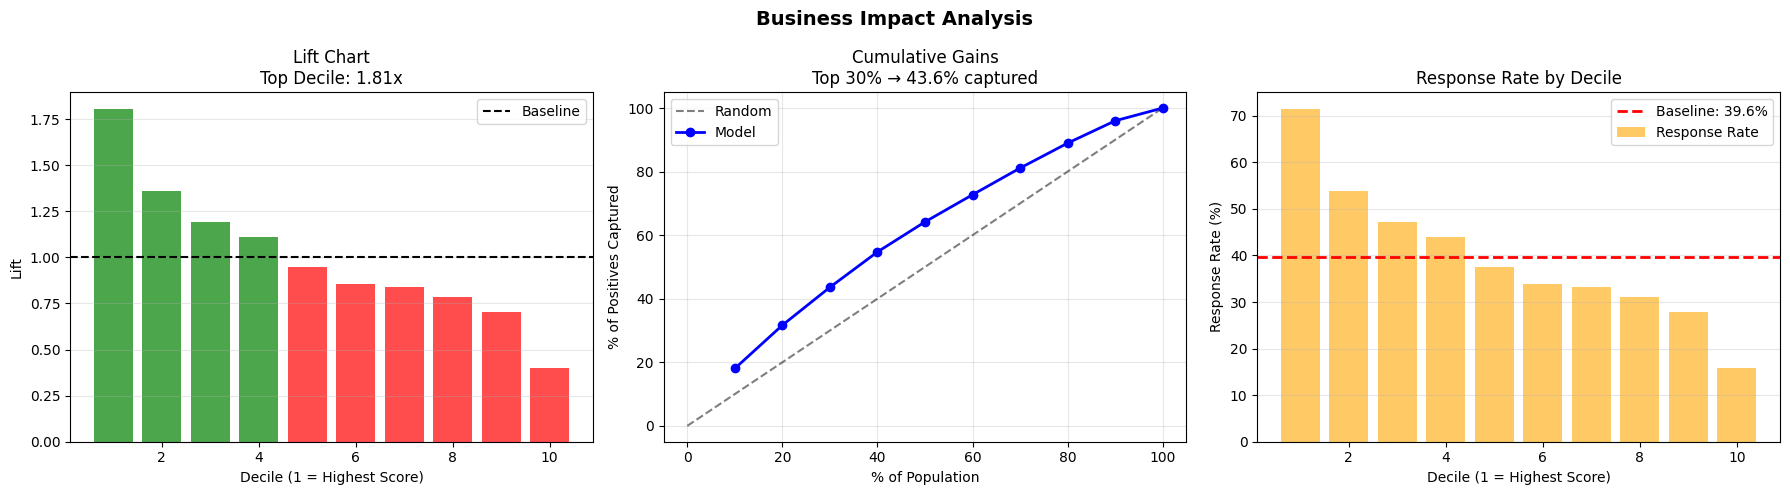

• Top Decile Lift: 0.40x
• Top 30% captures: 43.6% of positives
• Baseline response rate: 39.6%
• Top decile response: 71.5%

📈 STEP 4: CONFUSION MATRIX
----------------------------------------


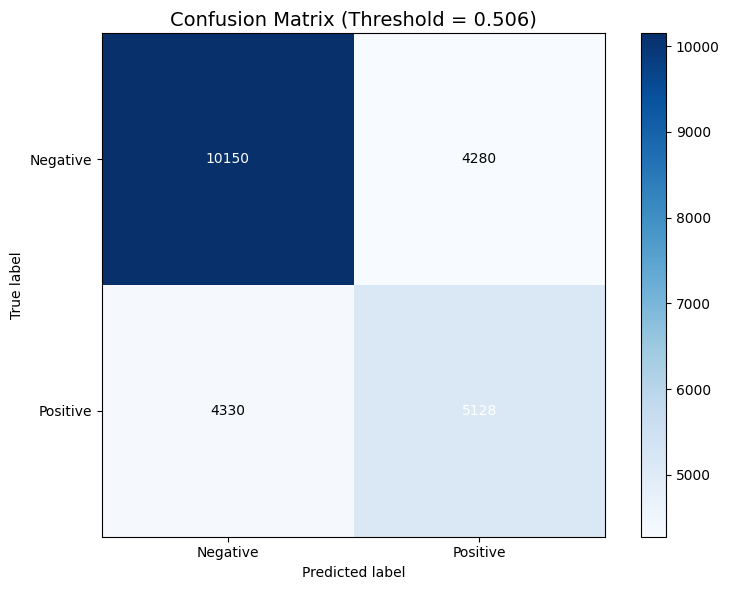

At threshold 0.506:
• Accuracy: 0.640
• Precision: 0.545
• Recall: 0.542
• F1-Score: 0.544
• True Positives: 5128
• False Positives: 4280
• True Negatives: 10150
• False Negatives: 4330

FINAL VALIDATION SUMMARY

✅ DISCRIMINATION POWER:
   KS Statistic: 0.246 (WEAK discrimination)

✅ BUSINESS VALUE:
   Efficiency: 0.40x better than random
   Coverage: Top 30% → 43.6% captured

✅ MODEL QUALITY:
   ROC-AUC: 0.6705 (Excellent if >0.8)
   PR-AUC: 0.5875 (Excellent if >0.7)

✅ OPERATIONAL METRICS:
   Optimal Threshold: 0.506
   Precision at threshold: 0.545
   Recall at threshold: 0.542

🧪 TEST 2: SEQUENCE FEATURES (Advanced)
✓ Model saved: sequence_prediction_model.pkl
✓ AUC: 0.662
COMPLETE MODEL VALIDATION PACKAGE

📊 STEP 1: DISCRIMINATION POWER
----------------------------------------


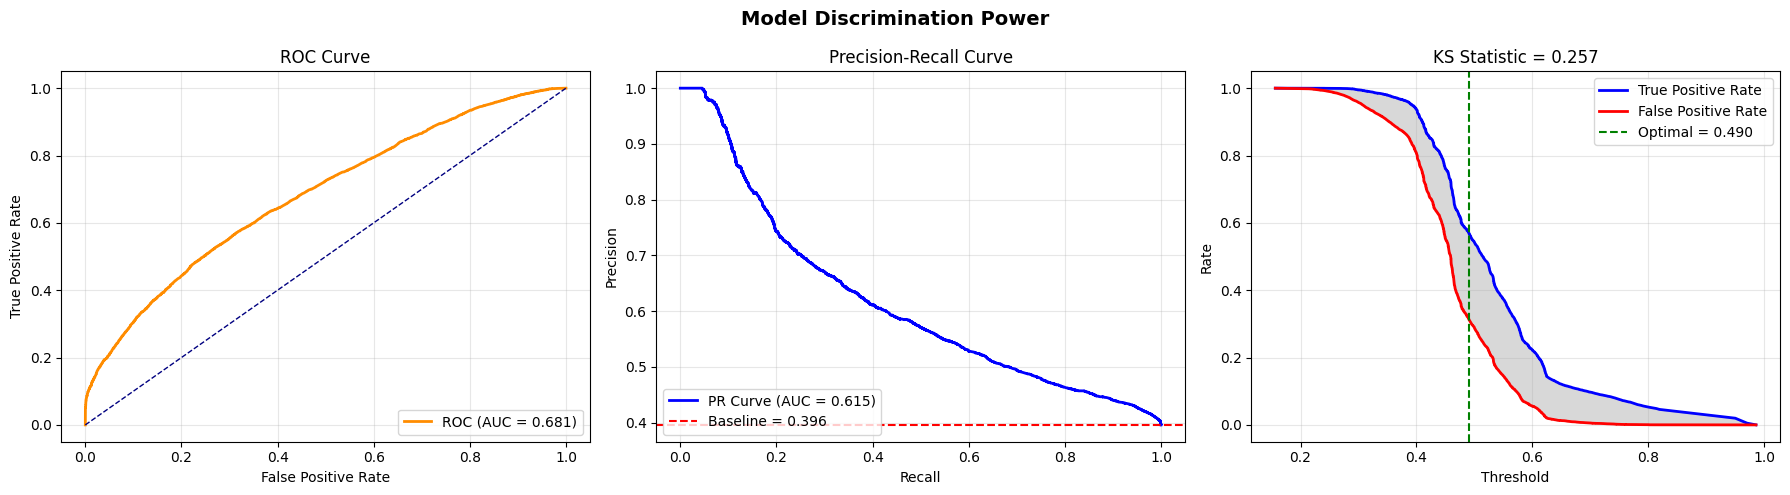

• ROC-AUC: 0.6812
• PR-AUC: 0.6154
• KS Statistic: 0.257 (WEAK discrimination)
• Optimal Threshold: 0.490

💼 STEP 2: BUSINESS IMPACT
----------------------------------------
Verification of decile assignment:
Decile 1 mean prob: 0.718
Decile 10 mean prob: 0.324


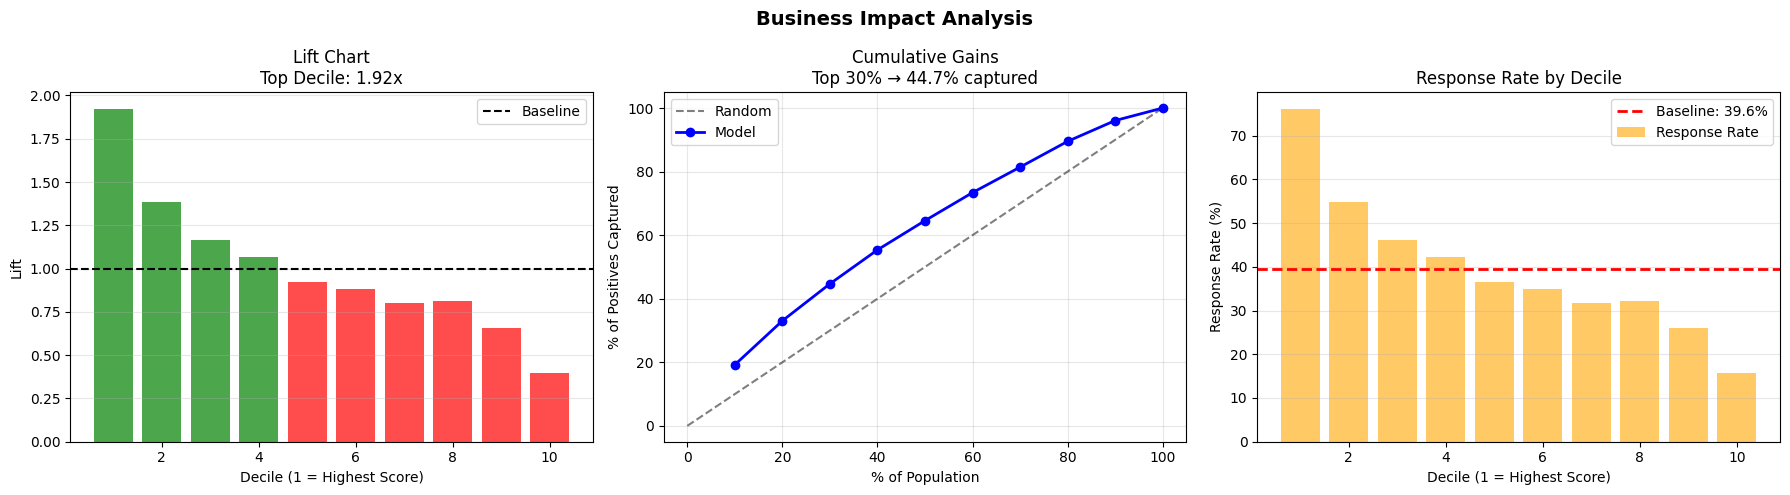

• Top Decile Lift: 0.39x
• Top 30% captures: 44.7% of positives
• Baseline response rate: 39.6%
• Top decile response: 76.1%

📈 STEP 4: CONFUSION MATRIX
----------------------------------------


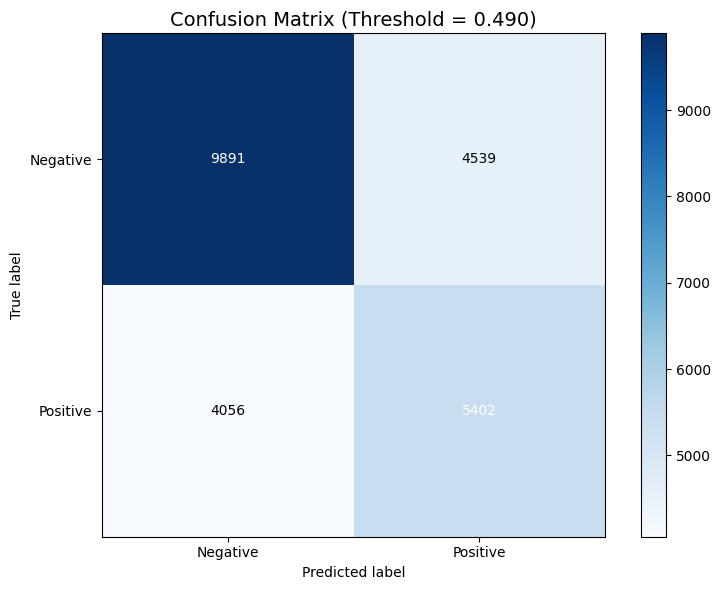

At threshold 0.490:
• Accuracy: 0.640
• Precision: 0.543
• Recall: 0.571
• F1-Score: 0.557
• True Positives: 5402
• False Positives: 4539
• True Negatives: 9891
• False Negatives: 4056

FINAL VALIDATION SUMMARY

✅ DISCRIMINATION POWER:
   KS Statistic: 0.257 (WEAK discrimination)

✅ BUSINESS VALUE:
   Efficiency: 0.39x better than random
   Coverage: Top 30% → 44.7% captured

✅ MODEL QUALITY:
   ROC-AUC: 0.6812 (Excellent if >0.8)
   PR-AUC: 0.6154 (Excellent if >0.7)

✅ OPERATIONAL METRICS:
   Optimal Threshold: 0.490
   Precision at threshold: 0.543
   Recall at threshold: 0.571

🧪 TEST 3: NEW FEATURES (Advanced)
✓ Model saved: sequence_prediction_model.pkl
✓ AUC: 0.696
COMPLETE MODEL VALIDATION PACKAGE

📊 STEP 1: DISCRIMINATION POWER
----------------------------------------


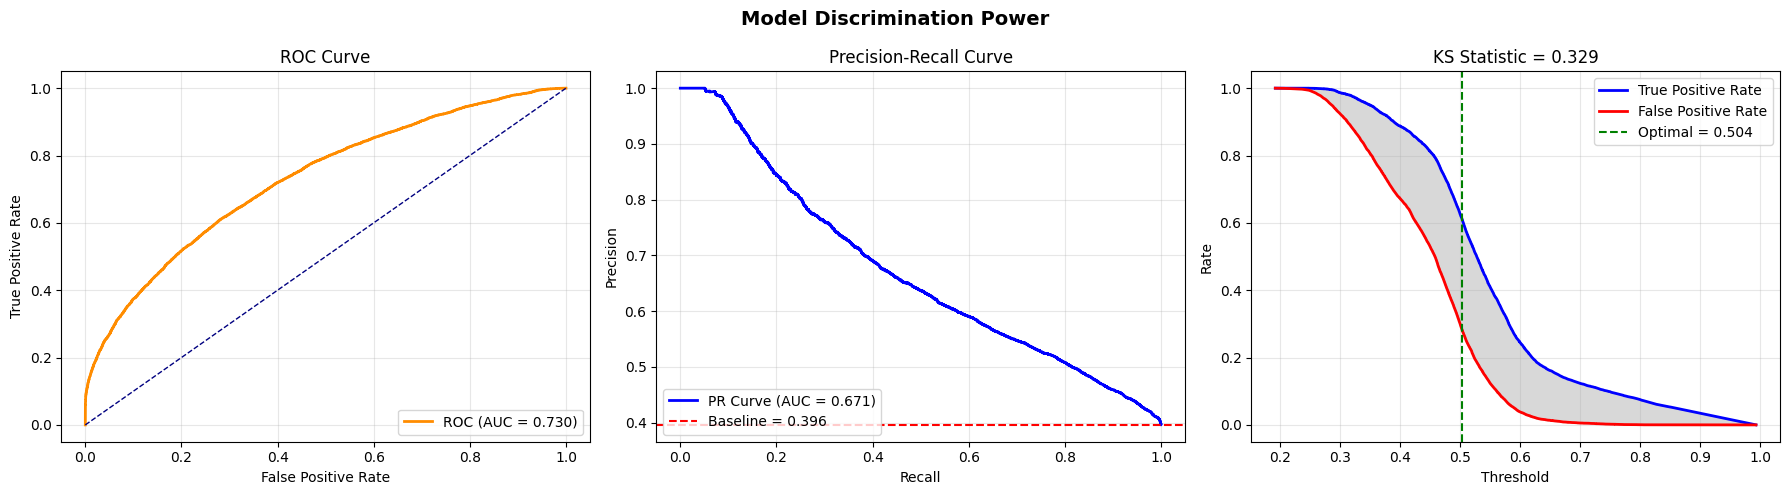

• ROC-AUC: 0.7297
• PR-AUC: 0.6708
• KS Statistic: 0.329 (MODERATE discrimination)
• Optimal Threshold: 0.504

💼 STEP 2: BUSINESS IMPACT
----------------------------------------
Verification of decile assignment:
Decile 1 mean prob: 0.743
Decile 10 mean prob: 0.296


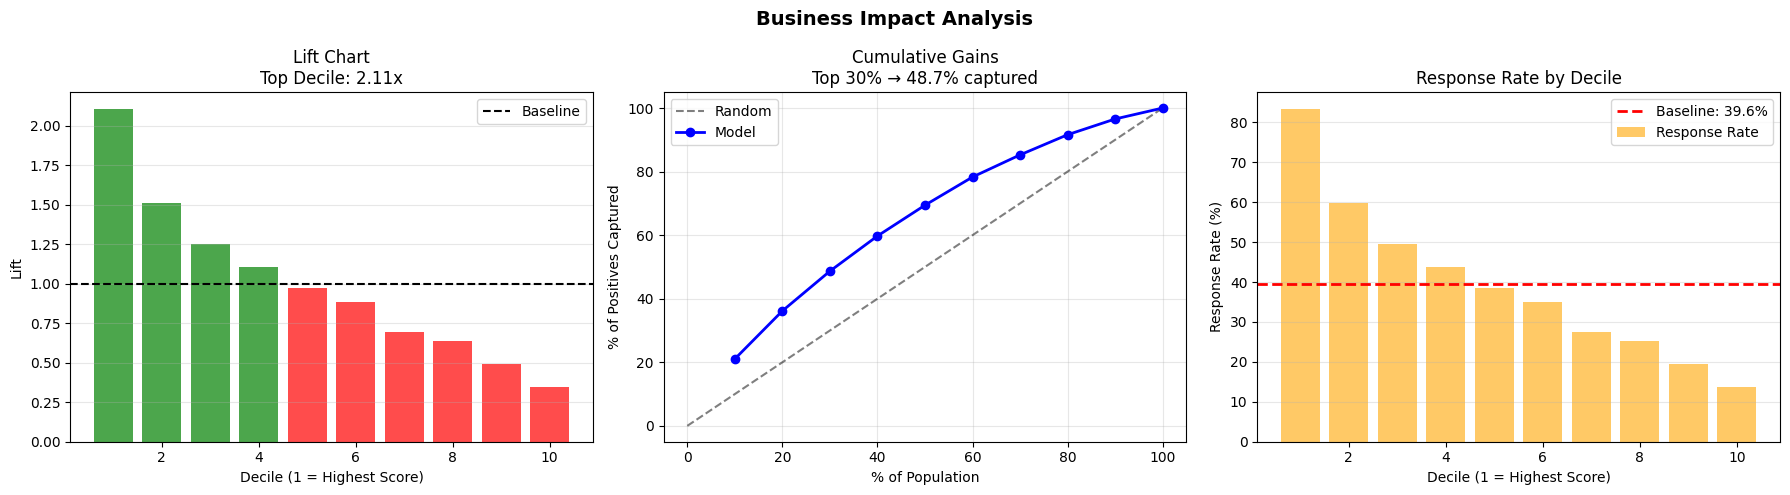

• Top Decile Lift: 0.34x
• Top 30% captures: 48.7% of positives
• Baseline response rate: 39.6%
• Top decile response: 83.4%

📈 STEP 4: CONFUSION MATRIX
----------------------------------------


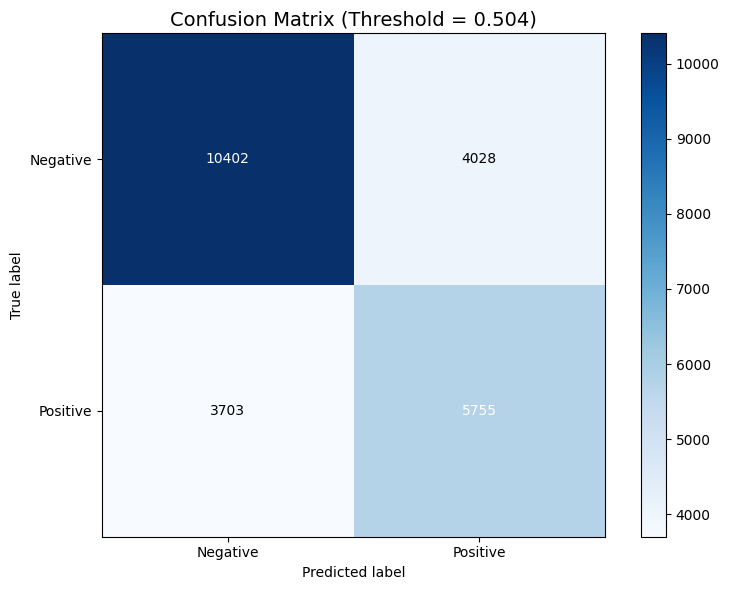

At threshold 0.504:
• Accuracy: 0.676
• Precision: 0.588
• Recall: 0.608
• F1-Score: 0.598
• True Positives: 5755
• False Positives: 4028
• True Negatives: 10402
• False Negatives: 3703

FINAL VALIDATION SUMMARY

✅ DISCRIMINATION POWER:
   KS Statistic: 0.329 (MODERATE discrimination)

✅ BUSINESS VALUE:
   Efficiency: 0.34x better than random
   Coverage: Top 30% → 48.7% captured

✅ MODEL QUALITY:
   ROC-AUC: 0.7297 (Excellent if >0.8)
   PR-AUC: 0.6708 (Excellent if >0.7)

✅ OPERATIONAL METRICS:
   Optimal Threshold: 0.504
   Precision at threshold: 0.588
   Recall at threshold: 0.608


{'y_true': array([0., 0., 1., ..., 0., 0., 0.], shape=(23888,)),
 'y_pred_proba': array([0.4554146 , 0.45335121, 0.38285601, ..., 0.47765739, 0.26967958,
        0.44939714], shape=(23888,)),
 'y_pred': array([0, 0, 0, ..., 0, 0, 0], shape=(23888,)),
 'roc_auc': 0.7296770256275438,
 'pr_auc': 0.6708312183142,
 'ks_statistic': np.float64(0.3293389148538229),
 'optimal_threshold': np.float64(0.5039240536065606),
 'top_decile_lift': np.float64(0.3446528951640178),
 'decile_stats':    decile  count  positives  mean_prob  response_rate      lift  \
 0       1   2389     1992.0   0.743131       0.833822  2.105977   
 1       2   2389     1429.0   0.586039       0.598158  1.510764   
 2       3   2389     1184.0   0.546471       0.495605  1.251745   
 3       4   2388     1045.0   0.517706       0.437605  1.105255   
 4       5   2389      917.0   0.495730       0.383843  0.969468   
 5       6   2389      838.0   0.473537       0.350774  0.885948   
 6       7   2388      659.0   0.446348   

In [3]:
new_df_ = create_brand_features(df_quotes)
brand_df = new_df_
new_df = create_model_features(df_quotes)

new_df = pd.merge(
    new_df, 
    new_df_, 
    on='numero_compte', 
    how='left',
    suffixes=('_dup', '')  # Explicit suffixes
)

columns_to_drop =  [x for x in new_df.columns if '_dup' in x]
new_df = new_df.drop(columns=columns_to_drop, errors='ignore')
print(len(new_df))

new_df_ = create_market_features(df_quotes)
market_df = new_df_
new_df = pd.merge(
    new_df, 
    new_df_, 
    on='numero_compte', 
    how='left',
    suffixes=('_dup', '')  # Explicit suffixes
)

columns_to_drop =  [x for x in new_df.columns if '_dup' in x]
new_df = new_df.drop(columns=columns_to_drop, errors='ignore')
print(len(new_df))

new_df_ = create_equipment_features(df_quotes)
equipment_df = new_df_
new_df = pd.merge(
    new_df, 
    new_df_, 
    on='numero_compte', 
    how='left',
    suffixes=('_dup', '')  # Explicit suffixes
)

columns_to_drop =  [x for x in new_df.columns if '_dup' in x]
new_df = new_df.drop(columns=columns_to_drop, errors='ignore')
print(len(new_df))

new_df_ = create_solution_complexity_features(df_quotes)
new_df = pd.merge(
    new_df, 
    new_df_, 
    on='numero_compte', 
    how='left',
    suffixes=('_dup', '')  # Explicit suffixes
)

columns_to_drop =  [x for x in new_df.columns if '_dup' in x]
new_df = new_df.drop(columns=columns_to_drop, errors='ignore')
print(len(new_df))

new_df_ = create_timeline_features(df_quotes)
new_df = pd.merge(
    new_df, 
    new_df_, 
    on='numero_compte', 
    how='left',
    suffixes=('_dup', '')  # Explicit suffixes
)

columns_to_drop =  [x for x in new_df.columns if '_dup' in x]
new_df = new_df.drop(columns=columns_to_drop, errors='ignore')
print(len(new_df))

new_df_ = create_advanced_timeline_features(df_quotes)
new_df = pd.merge(
    new_df, 
    new_df_, 
    on='numero_compte', 
    how='left',
    suffixes=('_dup', '')  # Explicit suffixes
)

columns_to_drop =  [x for x in new_df.columns if '_dup' in x]
new_df = new_df.drop(columns=columns_to_drop, errors='ignore')
print(len(new_df))

new_df_ = create_timeline_interaction_features(new_df_, brand_df, equipment_df)
new_df = pd.merge(
    new_df, 
    new_df_, 
    on='numero_compte', 
    how='left',
    suffixes=('_dup', '')  # Explicit suffixes
)

columns_to_drop =  [x for x in new_df.columns if '_dup' in x]
new_df = new_df.drop(columns=columns_to_drop, errors='ignore')
print(len(new_df))

new_df_ = create_commercial_role_features(df_quotes)
new_df = pd.merge(
    new_df, 
    new_df_, 
    on='numero_compte', 
    how='left',
    suffixes=('_dup', '')  # Explicit suffixes
)

columns_to_drop =  [x for x in new_df.columns if '_dup' in x]
new_df = new_df.drop(columns=columns_to_drop, errors='ignore')
print(len(new_df))

new_df_ = create_process_features(df_quotes)
new_df = pd.merge(
    new_df, 
    new_df_, 
    on='numero_compte', 
    how='left',
    suffixes=('_dup', '')  # Explicit suffixes
)

columns_to_drop =  [x for x in new_df.columns if '_dup' in x]
new_df = new_df.drop(columns=columns_to_drop, errors='ignore')
print(len(new_df))

new_df_ = create_correction_features(df_quotes)
new_df = pd.merge(
    new_df, 
    new_df_, 
    on='numero_compte', 
    how='left',
    suffixes=('_dup', '')  # Explicit suffixes
)

columns_to_drop =  [x for x in new_df.columns if '_dup' in x]
new_df = new_df.drop(columns=columns_to_drop, errors='ignore')
print(len(new_df))

sequence_df = pd.merge(
    sequence_df, 
    customer_df, 
    on='numero_compte', 
    how='left',
    suffixes=('_dup', '')  # Explicit suffixes
)

columns_to_drop =  [x for x in sequence_df.columns if '_dup' in x]
sequence_df = sequence_df.drop(columns=columns_to_drop, errors='ignore')


new_df = pd.merge(
    new_df,
    sequence_df, 
    on='numero_compte', 
    how='left',
    suffixes=('_dup', '')  # Explicit suffixes
)

columns_to_drop =  [x for x in new_df.columns if '_dup' in x]
new_df = new_df.drop(columns=columns_to_drop, errors='ignore')



print("Columns:", sequence_df.columns.tolist())

# Now it's clear which column is which
y_new = new_df['converted']  # From sequence features
y_sequence = sequence_df['converted']  # From sequence features
y_customer = customer_df['converted']  # From customer features

# For modeling, use the sequence version
X_customer = customer_df.drop(columns=['numero_compte', 'converted'], errors='ignore')
X_customer_clean, y_customer_clean = prepare_features(X_customer, y_customer, "Customer Features")


X_sequence = sequence_df.drop(columns=['numero_compte', 'converted'], errors='ignore')
X_sequence_clean, y_sequence_clean = prepare_features(X_sequence, y_sequence, "Sequence Features")


X_new = new_df.drop(columns=['numero_compte', 'converted'], errors='ignore')
X_new_clean, y_new_clean = prepare_features(X_new, y_new, "New Features")





print("\n" + "="*80)
print("TESTING FEATURE IMPROVEMENT")
print("="*80)

# Test 1: Customer features only (baseline)
print("\n🧪 TEST 1: ENHANCED CUSTOMER FEATURES (Baseline)")
result = train_rf(X_customer_clean, y_customer_clean, 'improved_customer_model')
df = X_customer_clean.copy()
df['converted'] = y_customer_clean
model_evaluation_report(df, result['model'], result['features'], 'converted')

# Test 2: Sequence features (if available)
print("\n🧪 TEST 2: SEQUENCE FEATURES (Advanced)")
result = train_rf(X_sequence_clean, y_sequence_clean, 'sequence_prediction_model')
df = X_sequence_clean.copy()
df['converted'] = y_sequence_clean
model_evaluation_report(df, result['model'], result['features'], 'converted')


# Test 3: New features 
print("\n🧪 TEST 3: NEW FEATURES (Advanced)")
result = train_rf(X_new_clean, y_new_clean, 'sequence_prediction_model')
__result = result
df = X_new_clean.copy()
df['converted'] = y_new_clean
model_evaluation_report(df, result['model'], result['features'], 'converted')

In [4]:
X_sequence_clean.columns

Index(['total_historical_quotes', 'had_historical_quotes',
       'avg_days_since_first_quote', 'std_days_since_first_quote',
       'avg_recent_quote_count', 'std_recent_quote_count',
       'avg_recent_avg_price', 'std_recent_avg_price', 'avg_recent_price_std',
       'std_recent_price_std', 'avg_recent_product_variety',
       'std_recent_product_variety', 'avg_current_price', 'std_current_price',
       'price_trend', 'total_quotes', 'avg_days_between_quotes',
       'std_days_between_quotes', 'max_days_between_quotes',
       'engagement_density', 'price_trajectory', 'unique_product_families',
       'product_consistency', 'avg_price', 'price_range', 'price_volatility',
       'avg_discount_pct', 'main_agency', 'main_region'],
      dtype='object')

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

def diagnose_removed_customers(prev_file, new_file):
    """
    Comprehensive diagnosis of what changed between dataset versions
    """
    print("=" * 100)
    print("COMPREHENSIVE CUSTOMER REMOVAL ANALYSIS")
    print("=" * 100)
    
    # Load both datasets
    df_prev = pd.read_csv(prev_file)
    df_new = pd.read_csv(new_file)
    
    # Ensure we have the key columns
    df_prev['dt_creation_devis'] = pd.to_datetime(df_prev['dt_creation_devis'])
    df_new['dt_creation_devis'] = pd.to_datetime(df_new['dt_creation_devis'])
    
    print(f"Previous dataset: {len(df_prev):,} quotes from {df_prev['numero_compte'].nunique():,} customers")
    print(f"New dataset: {len(df_new):,} quotes from {df_new['numero_compte'].nunique():,} customers")
    print(f"Customers removed: {df_prev['numero_compte'].nunique() - df_new['numero_compte'].nunique():,}")
    print(f"Quotes removed: {len(df_prev) - len(df_new):,}")
    
    # Identify removed and added customers
    prev_customers = set(df_prev['numero_compte'].unique())
    new_customers = set(df_new['numero_compte'].unique())
    
    removed_customers = prev_customers - new_customers
    added_customers = new_customers - prev_customers
    
    print(f"\n1. CUSTOMER CHANGES:")
    print(f"   Removed customers: {len(removed_customers):,}")
    print(f"   Added customers: {len(added_customers):,}")
    print(f"   Common customers: {len(prev_customers & new_customers):,}")
    
    # Get data for removed customers
    df_removed = df_prev[df_prev['numero_compte'].isin(removed_customers)].copy()
    df_kept = df_prev[df_prev['numero_compte'].isin(prev_customers & new_customers)].copy()
    df_added = df_new[df_new['numero_compte'].isin(added_customers)].copy()
    
    # ANALYSIS 1: BASIC CHARACTERISTICS
    print(f"\n{'='*50}")
    print("ANALYSIS 1: BASIC CUSTOMER CHARACTERISTICS")
    print('='*50)
    
    def analyze_customer_group(df, group_name):
        """Analyze a group of customers"""
        if len(df) == 0:
            print(f"\n{group_name}: No data")
            return {}
        
        # Customer-level stats
        customer_stats = df.groupby('numero_compte').agg({
            'numero_compte': 'count',
            'fg_devis_accepte': 'max',
            'mt_apres_remise_ht_devis': 'mean',
            'dt_creation_devis': ['min', 'max']
        }).reset_index()
        
        customer_stats.columns = ['numero_compte', 'total_quotes', 'converted', 
                                  'avg_price', 'first_quote_date', 'last_quote_date']
        
        # Calculate tenure
        customer_stats['tenure_days'] = (customer_stats['last_quote_date'] - 
                                        customer_stats['first_quote_date']).dt.days
        
        stats = {
            'count': len(customer_stats),
            'avg_quotes': customer_stats['total_quotes'].mean(),
            'conversion_rate': customer_stats['converted'].mean(),
            'avg_price': customer_stats['avg_price'].mean(),
            'avg_tenure': customer_stats['tenure_days'].mean(),
            'single_quote_pct': (customer_stats['total_quotes'] == 1).mean() * 100
        }
        
        print(f"\n{group_name}:")
        print(f"  • Customers: {stats['count']:,}")
        print(f"  • Avg quotes per customer: {stats['avg_quotes']:.2f}")
        print(f"  • Conversion rate: {stats['conversion_rate']:.2%}")
        print(f"  • Avg quote price: €{stats['avg_price']:,.0f}")
        print(f"  • Avg tenure (days): {stats['avg_tenure']:.0f}")
        print(f"  • Single-quote customers: {stats['single_quote_pct']:.1f}%")
        
        return stats
    
    # Analyze all groups
    removed_stats = analyze_customer_group(df_removed, "REMOVED CUSTOMERS")
    kept_stats = analyze_customer_group(df_kept, "RETAINED CUSTOMERS")
    added_stats = analyze_customer_group(df_added, "NEWLY ADDED CUSTOMERS")
    
    # ANALYSIS 2: TEMPORAL PATTERNS
    print(f"\n{'='*50}")
    print("ANALYSIS 2: TEMPORAL PATTERNS")
    print('='*50)
    
    def analyze_temporal_patterns(df, group_name):
        """Analyze when these customers were active"""
        if len(df) == 0:
            return
        
        df['quote_year_month'] = df['dt_creation_devis'].dt.to_period('M')
        monthly_counts = df.groupby('quote_year_month').agg({
            'numero_compte': 'nunique',
            'fg_devis_accepte': 'mean'
        }).reset_index()
        
        monthly_counts.columns = ['period', 'unique_customers', 'conversion_rate']
        
        print(f"\n{group_name} - Temporal patterns:")
        print(f"  • First quote date: {df['dt_creation_devis'].min().date()}")
        print(f"  • Last quote date: {df['dt_creation_devis'].max().date()}")
        print(f"  • Peak month: {monthly_counts.loc[monthly_counts['unique_customers'].idxmax(), 'period']}")
        
        # Recent vs historical
        cutoff_date = pd.Timestamp('2024-06-01')  # Adjust based on your data
        recent_mask = df['dt_creation_devis'] >= cutoff_date
        
        if recent_mask.any():
            recent_pct = recent_mask.mean() * 100
            print(f"  • Quotes in last 6 months: {recent_pct:.1f}%")
    
    analyze_temporal_patterns(df_removed, "Removed customers")
    analyze_temporal_patterns(df_kept, "Retained customers")
    analyze_temporal_patterns(df_added, "Added customers")
    
    # ANALYSIS 3: PRODUCT & COMMERCIAL PATTERNS
    print(f"\n{'='*50}")
    print("ANALYSIS 3: PRODUCT & COMMERCIAL CHARACTERISTICS")
    print('='*50)
    
    def analyze_product_commercial(df, group_name):
        """Analyze what products and commercial patterns"""
        if len(df) == 0:
            return
        
        print(f"\n{group_name}:")
        
        # Product family (use new column if available, otherwise old)
        product_col = 'regroup_famille_equipement_produit' if 'regroup_famille_equipement_produit' in df.columns else 'famille_equipement_produit'
        if product_col in df.columns:
            top_products = df[product_col].value_counts().head(3)
            print(f"  Top 3 equipment types:")
            for product, count in top_products.items():
                pct = count / len(df) * 100
                print(f"    • {product}: {pct:.1f}%")
        
        # Brands if available
        if 'marque_produit' in df.columns:
            top_brands = df['marque_produit'].value_counts().head(3)
            print(f"  Top 3 brands:")
            for brand, count in top_brands.items():
                pct = count / len(df) * 100
                print(f"    • {brand}: {pct:.1f}%")
        
        # Commercial function if available
        if 'fonction_commercial' in df.columns:
            top_funcs = df['fonction_commercial'].value_counts().head(3)
            print(f"  Top 3 commercial functions:")
            for func, count in top_funcs.items():
                pct = count / len(df) * 100
                print(f"    • {func}: {pct:.1f}%")
    
    analyze_product_commercial(df_removed, "Removed customers")
    analyze_product_commercial(df_kept, "Retained customers")
    analyze_product_commercial(df_added, "Added customers")
    
    # ANALYSIS 4: CONVERSION PATTERNS
    print(f"\n{'='*50}")
    print("ANALYSIS 4: CONVERSION BEHAVIOR ANALYSIS")
    print('='*50)
    
    def analyze_conversion_patterns(df, group_name):
        """Analyze how conversion happens in this group"""
        if len(df) == 0:
            return
        
        # Conversion by quote position
        df = df.sort_values(['numero_compte', 'dt_creation_devis']).copy()
        df['quote_rank'] = df.groupby('numero_compte').cumcount() + 1
        
        # What quote position converts?
        conversion_by_position = df.groupby('quote_rank')['fg_devis_accepte'].agg(['mean', 'count']).reset_index()
        conversion_by_position.columns = ['quote_position', 'conversion_rate', 'count']
        
        first_quote_conversion = conversion_by_position[conversion_by_position['quote_position'] == 1]['conversion_rate'].values
        if len(first_quote_conversion) > 0:
            print(f"\n{group_name}:")
            print(f"  • First quote conversion rate: {first_quote_conversion[0]:.2%}")
        
        # Time to conversion for converters
        converters = df[df['fg_devis_accepte'] == 1]
        if len(converters) > 0:
            # Get first conversion date for each customer
            first_conversion = converters.groupby('numero_compte')['dt_creation_devis'].min().reset_index()
            first_conversion.columns = ['numero_compte', 'first_conversion_date']
            
            # Merge with first quote date
            first_quote = df.groupby('numero_compte')['dt_creation_devis'].min().reset_index()
            first_quote.columns = ['numero_compte', 'first_quote_date']
            
            conversion_timing = pd.merge(first_conversion, first_quote, on='numero_compte')
            conversion_timing['days_to_convert'] = (conversion_timing['first_conversion_date'] - 
                                                   conversion_timing['first_quote_date']).dt.days
            
            if len(conversion_timing) > 0:
                print(f"  • Avg days to convert: {conversion_timing['days_to_convert'].mean():.0f} days")
    
    analyze_conversion_patterns(df_removed, "Removed customers")
    analyze_conversion_patterns(df_kept, "Retained customers")
    analyze_conversion_patterns(df_added, "Added customers")
    
    # ANALYSIS 5: NEW FEATURES ANALYSIS (Critical for new dataset)
    print(f"\n{'='*50}")
    print("ANALYSIS 5: NEW DATASET FEATURES COMPARISON")
    print('='*50)
    
    # Check which new features are available
    new_features = ['statut_client', 'marque_produit', 'regroup_famille_equipement_produit',
                    'fonction_commercial', 'fg_nouveau_process_relance_devis', 'dt_prem_devis']
    
    available_features = [f for f in new_features if f in df_new.columns]
    print(f"New features available in v3: {available_features}")
    
    # Compare feature distributions between removed and kept customers
    if 'statut_client' in df_removed.columns:
        print(f"\nCLIENT STATUS DISTRIBUTION:")
        
        for group_name, group_df in [("Removed", df_removed), ("Retained", df_kept), ("Added", df_added)]:
            if len(group_df) > 0 and 'statut_client' in group_df.columns:
                status_dist = group_df['statut_client'].value_counts(normalize=True)
                print(f"\n{group_name} customers:")
                for status, pct in status_dist.items():
                    print(f"  • {status}: {pct:.1%}")
    
    if 'fg_nouveau_process_relance_devis' in df_removed.columns:
        print(f"\nNEW PROCESS ADOPTION:")
        
        for group_name, group_df in [("Removed", df_removed), ("Retained", df_kept), ("Added", df_added)]:
            if len(group_df) > 0 and 'fg_nouveau_process_relance_devis' in group_df.columns:
                process_usage = group_df['fg_nouveau_process_relance_devis'].mean()
                print(f"  {group_name}: {process_usage:.1%} use new process")
    
    # ANALYSIS 6: PREDICTIVE POWER ANALYSIS
    print(f"\n{'='*50}")
    print("ANALYSIS 6: PREDICTIVE POWER OF REMOVED VS RETAINED")
    print('='*50)
    
    # Create simple features to see predictive patterns
    def create_diagnostic_features(df):
        """Create features to understand predictive patterns"""
        if len(df) == 0:
            return pd.DataFrame()
        
        features = []
        
        for customer_id, customer_data in df.groupby('numero_compte'):
            f = {'customer_id': customer_id}
            
            # Basic features
            f['total_quotes'] = len(customer_data)
            f['converted'] = customer_data['fg_devis_accepte'].max()
            f['avg_price'] = customer_data['mt_apres_remise_ht_devis'].mean()
            
            # Temporal
            if len(customer_data) > 1:
                time_span = (customer_data['dt_creation_devis'].max() - 
                            customer_data['dt_creation_devis'].min()).days + 1
                f['engagement_density'] = len(customer_data) / time_span
            else:
                f['engagement_density'] = 1
            
            # Product variety
            product_col = 'regroup_famille_equipement_produit' if 'regroup_famille_equipement_produit' in customer_data.columns else 'famille_equipement_produit'
            if product_col in customer_data.columns:
                f['product_variety'] = customer_data[product_col].nunique()
            
            features.append(f)
        
        return pd.DataFrame(features)
    
    # Create features for each group
    removed_features = create_diagnostic_features(df_removed)
    kept_features = create_diagnostic_features(df_kept)
    
    if len(removed_features) > 0 and len(kept_features) > 0:
        print("\nFEATURE COMPARISON (Mean values):")
        print("\nFeature                | Removed | Retained | Difference")
        print("-" * 55)
        
        for feature in ['total_quotes', 'converted', 'avg_price', 'engagement_density']:
            if feature in removed_features.columns and feature in kept_features.columns:
                removed_mean = removed_features[feature].mean()
                kept_mean = kept_features[feature].mean()
                diff = removed_mean - kept_mean
                print(f"{feature:20} | {removed_mean:7.2f} | {kept_mean:8.2f} | {diff:+.3f}")
    
    # ANALYSIS 7: BUSINESS IMPACT ANALYSIS
    print(f"\n{'='*50}")
    print("ANALYSIS 7: BUSINESS IMPACT OF CUSTOMER REMOVAL")
    print('='*50)
    
    # Estimate business impact
    if len(df_removed) > 0:
        # Potential lost revenue
        avg_quote_value = df_removed['mt_apres_remise_ht_devis'].mean()
        conversion_rate = df_removed['fg_devis_accepte'].mean()
        potential_customers = len(removed_customers)
        
        print(f"\nPOTENTIAL BUSINESS IMPACT:")
        print(f"• Customers removed: {potential_customers:,}")
        print(f"• Avg quote value: €{avg_quote_value:,.0f}")
        print(f"• Conversion rate: {conversion_rate:.1%}")
        print(f"• Estimated lost revenue opportunity: €{potential_customers * avg_quote_value * conversion_rate:,.0f}")
        
        # Compare with retained
        avg_quote_kept = df_kept['mt_apres_remise_ht_devis'].mean()
        conversion_kept = df_kept['fg_devis_accepte'].mean()
        
        print(f"\nCOMPARISON WITH RETAINED CUSTOMERS:")
        print(f"• Quote value difference: €{avg_quote_value - avg_quote_kept:+,.0f}")
        print(f"• Conversion rate difference: {conversion_rate - conversion_kept:+.1%}")
    
    # ANALYSIS 8: RECOMMENDATIONS
    print(f"\n{'='*50}")
    print("ANALYSIS 8: DIAGNOSTIC RECOMMENDATIONS")
    print('='*50)
    
    # Generate recommendations based on findings
    recommendations = []
    
    # Check if removed customers were systematically different
    if len(df_removed) > 0 and len(df_kept) > 0:
        # Check conversion rate difference
        conv_diff = df_removed['fg_devis_accepte'].mean() - df_kept['fg_devis_accepte'].mean()
        
        if conv_diff < -0.05:  # Removed customers had much lower conversion
            recommendations.append("REMOVED CUSTOMERS WERE LOW-CONVERTERS: This is GOOD data cleanup")
            recommendations.append("→ Your model should perform BETTER on cleaner data")
            recommendations.append("→ Need to adjust expectations: Original model was trained on noisy data")
        
        elif conv_diff > 0.05:  # Removed customers had higher conversion
            recommendations.append("⚠️ WARNING: REMOVED CUSTOMERS WERE HIGH-CONVERTERS")
            recommendations.append("→ This explains the accuracy drop")
            recommendations.append("→ Need to investigate WHY high-converters were removed")
        
        else:
            recommendations.append("Removed and retained customers have similar conversion rates")
            recommendations.append("→ The accuracy drop may be due to OTHER factors")
    
    # Check temporal patterns
    if len(df_removed) > 0:
        removed_end_date = df_removed['dt_creation_devis'].max()
        kept_end_date = df_kept['dt_creation_devis'].max()
        
        if (kept_end_date - removed_end_date).days > 180:
            recommendations.append("Removed customers were from older time periods")
            recommendations.append("→ This is likely intentional data archiving")
            recommendations.append("→ Consider adding time-based features to handle recency effects")
    
    # Check for systematic patterns in removed customers
    if 'statut_client' in df_removed.columns:
        status_dist_removed = df_removed['statut_client'].value_counts(normalize=True)
        status_dist_kept = df_kept['statut_client'].value_counts(normalize=True)
        
        # Check if specific status was disproportionately removed
        for status in status_dist_removed.index:
            removed_pct = status_dist_removed[status]
            kept_pct = status_dist_kept.get(status, 0)
            
            if abs(removed_pct - kept_pct) > 0.1:  # 10% difference
                recommendations.append(f"⚠️ {status} customers disproportionately affected")
                recommendations.append(f"→ Removed: {removed_pct:.1%}, Kept: {kept_pct:.1%}")
    
    # Print recommendations
    if recommendations:
        print("\nRECOMMENDATIONS BASED ON ANALYSIS:")
        for i, rec in enumerate(recommendations, 1):
            print(f"{i}. {rec}")
    else:
        print("\nNo clear patterns detected in removed customers.")
    
    # Save detailed analysis to file
    print(f"\n{'='*50}")
    print("SAVING DETAILED ANALYSIS")
    print('='*50)
    
    # Create comparison DataFrame
    comparison_data = []
    
    for group_name, group_df in [("Removed", df_removed), ("Retained", df_kept), ("Added", df_added)]:
        if len(group_df) > 0:
            comparison_data.append({
                'Group': group_name,
                'Customers': group_df['numero_compte'].nunique(),
                'Quotes': len(group_df),
                'Avg Quotes per Customer': len(group_df) / group_df['numero_compte'].nunique() if group_df['numero_compte'].nunique() > 0 else 0,
                'Conversion Rate': group_df['fg_devis_accepte'].mean(),
                'Avg Quote Value': group_df['mt_apres_remise_ht_devis'].mean(),
                'First Quote Date': group_df['dt_creation_devis'].min().date(),
                'Last Quote Date': group_df['dt_creation_devis'].max().date()
            })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Save to CSV
    comparison_df.to_csv('data/customer_removal_analysis.csv', index=False)
    print(f"✓ Detailed analysis saved to: data/customer_removal_analysis.csv")
    
    # Return the data for further analysis
    return {
        'df_removed': df_removed,
        'df_kept': df_kept,
        'df_added': df_added,
        'removed_customers': removed_customers,
        'kept_customers': prev_customers & new_customers,
        'added_customers': added_customers,
        'comparison_df': comparison_df
    }

# Run the analysis
if __name__ == "__main__":
    prev_file = "data/data_hes_quotes_france_202512-2.csv"
    new_file = "data/data_hes_quotes_france_202512-3.csv"
    
    print("Starting comprehensive customer removal analysis...")
    results = diagnose_removed_customers(prev_file, new_file)
    
    # Additional targeted analysis based on initial findings
    print(f"\n{'='*100}")
    print("ADDITIONAL TARGETED ANALYSIS")
    print('='*100)
    
    if results['df_removed'] is not None and len(results['df_removed']) > 0:
        # Check specific hypotheses
        
        # Hypothesis 1: Were removed customers mostly single-quote?
        removed_customer_quotes = results['df_removed'].groupby('numero_compte').size()
        single_quote_removed = (removed_customer_quotes == 1).mean() * 100
        
        kept_customer_quotes = results['df_kept'].groupby('numero_compte').size()
        single_quote_kept = (kept_customer_quotes == 1).mean() * 100
        
        print(f"\nSINGLE-QUOTE CUSTOMER ANALYSIS:")
        print(f"• Removed customers: {single_quote_removed:.1f}% had only one quote")
        print(f"• Retained customers: {single_quote_kept:.1f}% had only one quote")
        
        if single_quote_removed > single_quote_kept + 10:
            print("→ REMOVAL BIAS: Single-quote customers disproportionately removed")
        
        # Hypothesis 2: Were removed customers from specific agencies/regions?
        if 'nom_agence' in results['df_removed'].columns:
            top_agencies_removed = results['df_removed']['nom_agence'].value_counts(normalize=True).head(3)
            top_agencies_kept = results['df_kept']['nom_agence'].value_counts(normalize=True).head(3)
            
            print(f"\nTOP AGENCIES ANALYSIS:")
            print("Removed customers - Top 3 agencies:")
            for agency, pct in top_agencies_removed.items():
                print(f"  • {agency}: {pct:.1%}")
            
            print("\nRetained customers - Top 3 agencies:")
            for agency, pct in top_agencies_kept.items():
                print(f"  • {agency}: {pct:.1%}")
        
        # Hypothesis 3: Time-based removal?
        print(f"\nTIME-BASED ANALYSIS:")
        print(f"Removed customers - Quote date range:")
        print(f"  • Earliest: {results['df_removed']['dt_creation_devis'].min().date()}")
        print(f"  • Latest: {results['df_removed']['dt_creation_devis'].max().date()}")
        
        print(f"\nRetained customers - Quote date range:")
        print(f"  • Earliest: {results['df_kept']['dt_creation_devis'].min().date()}")
        print(f"  • Latest: {results['df_kept']['dt_creation_devis'].max().date()}")
        
        # Check if removed customers are from older time periods
        removed_latest = results['df_removed']['dt_creation_devis'].max()
        kept_latest = results['df_kept']['dt_creation_devis'].max()
        
        if (kept_latest - removed_latest).days > 90:
            print(f"\n→ TIME BIAS: Removed customers are from older time periods")
            print(f"  Latest removed quote: {removed_latest.date()}")
            print(f"  Latest kept quote: {kept_latest.date()}")
            print(f"  Difference: {(kept_latest - removed_latest).days} days")

Starting comprehensive customer removal analysis...
COMPREHENSIVE CUSTOMER REMOVAL ANALYSIS
Previous dataset: 38,697 quotes from 25,940 customers
New dataset: 34,275 quotes from 23,898 customers
Customers removed: 2,042
Quotes removed: 4,422

1. CUSTOMER CHANGES:
   Removed customers: 3,031
   Added customers: 989
   Common customers: 22,909

ANALYSIS 1: BASIC CUSTOMER CHARACTERISTICS

REMOVED CUSTOMERS:
  • Customers: 3,031
  • Avg quotes per customer: 1.18
  • Conversion rate: 45.20%
  • Avg quote price: €3,607
  • Avg tenure (days): 14
  • Single-quote customers: 85.7%

RETAINED CUSTOMERS:
  • Customers: 22,909
  • Avg quotes per customer: 1.53
  • Conversion rate: 40.63%
  • Avg quote price: €7,070
  • Avg tenure (days): 23
  • Single-quote customers: 65.5%

NEWLY ADDED CUSTOMERS:
  • Customers: 989
  • Avg quotes per customer: 1.30
  • Conversion rate: 21.33%
  • Avg quote price: €6,567
  • Avg tenure (days): 0
  • Single-quote customers: 75.5%

ANALYSIS 2: TEMPORAL PATTERNS

Remo

In [6]:
import time


In [7]:
def benchmark_function(func, *args, **kwargs):
    start = time.time()
    result = func(*args, **kwargs)
    end = time.time()
    return result, end - start

# Test both versions
original_time = benchmark_function(create_customer_features, df_quotes)[1]
print(original_time)

Creating OPTIMIZED customer features (mode: first_conversion)...
  Filtering post-first-purchase data...
  Customers: 23,888, Quotes: 33,247
  Calculating features...
  Calculating price trajectory (optimized)...
✓ Created 14 leakage-free features
→ 23,888 customers | 39.6% converters
⏱️  Execution time: 9.0 seconds
⚠️  9.0s (target was 3s)
9.026930570602417


In [8]:
import numpy as np
import pandas as pd
from collections import Counter
import re

import pandas as pd
import numpy as np
import time

import pandas as pd
import numpy as np
import time

def create_customer_features_ultrafast(
    df: pd.DataFrame,
    target_type: str = 'first_conversion',
    date_col: str = 'dt_creation_devis',
    customer_col: str = 'numero_compte',
    accept_col: str = 'fg_devis_accepte',
    price_col: str = 'mt_apres_remise_ht_devis',
    family_col: str = 'famille_equipement_produit',
    agency_col: str = 'nom_agence',
    region_col: str = 'nom_region',
    discount_col: str = 'mt_remise_exceptionnelle_ht',
    ttc_col: str = 'mt_ttc_apres_aide_devis'
) -> pd.DataFrame:
    """
    ULTRA-FAST VERSION - Should execute in ~3 seconds
    Removes expensive operations, uses numpy optimizations
    """
    print(f"Creating ULTRA-FAST customer features (mode: {target_type})...")
    start_time = time.time()
    
    # Make a copy (but minimal)
    df = df.copy()
    
    # Fast date conversion
    if not pd.api.types.is_datetime64_any_dtype(df[date_col]):
        df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    
    # ─── FAST Filter for pre-first-purchase data ─────────────────────
    filter_time = time.time()
    if target_type == 'first_conversion':
        # Use group indices trick - FASTEST method
        groups = df.groupby(customer_col).indices
        filtered_indices = []
        
        for cust_idx in groups.values():
            # Get customer data indices
            customer_data = df.iloc[cust_idx]
            
            # Find first conversion
            accept_mask = customer_data[accept_col] == 1
            if accept_mask.any():
                # Get index of first conversion
                first_accept_idx = accept_mask.idxmax()
                # Keep only indices up to and including first conversion
                keep_mask = customer_data.index <= first_accept_idx
                filtered_indices.extend(customer_data.index[keep_mask])
            else:
                # No conversion, keep all
                filtered_indices.extend(cust_idx)
        
        df_filtered = df.loc[filtered_indices].copy()
    else:
        df_filtered = df.copy()
    
    print(f"  Filter time: {time.time() - filter_time:.1f}s")
    
    # Store original for target (just the target calculation)
    target_series = df.groupby(customer_col)[accept_col].max()
    
    # Sort once
    df_filtered = df_filtered.sort_values([customer_col, date_col])
    
    # Get unique customers for pre-allocation
    customer_ids = df_filtered[customer_col].unique()
    n_customers = len(customer_ids)
    
    print(f"  Processing {n_customers:,} customers, {len(df_filtered):,} quotes...")
    
    # ─── PRE-ALLOCATE arrays for results ────────────────────────────
    calc_time = time.time()
    
    # Initialize results dictionary with numpy arrays
    results = {
        customer_col: customer_ids,
        'total_quotes': np.zeros(n_customers, dtype=int),
        'unique_product_families': np.zeros(n_customers, dtype=int),
        'avg_price': np.zeros(n_customers, dtype=float),
        'min_price': np.zeros(n_customers, dtype=float),
        'max_price': np.zeros(n_customers, dtype=float),
        'price_std': np.zeros(n_customers, dtype=float),
        'avg_discount_pct': np.zeros(n_customers, dtype=float),
        'avg_days_between_quotes': np.zeros(n_customers, dtype=float),
        'std_days_between_quotes': np.zeros(n_customers, dtype=float),
        'max_days_between_quotes': np.zeros(n_customers, dtype=float),
        'engagement_density': np.zeros(n_customers, dtype=float),
        'price_trajectory': np.zeros(n_customers, dtype=float),
        'main_agency': ['missing'] * n_customers,
        'main_region': ['missing'] * n_customers,
    }
    
    # Create customer index mapping for fast lookup
    cust_to_idx = {cust: i for i, cust in enumerate(customer_ids)}
    df_filtered['cust_idx'] = df_filtered[customer_col].map(cust_to_idx)
    
    # Convert to numpy arrays for speed
    cust_indices = df_filtered['cust_idx'].values
    dates_np = df_filtered[date_col].values.astype('datetime64[ns]')
    prices_np = df_filtered[price_col].values.astype(float)
    families_np = df_filtered[family_col].fillna('').values
    agencies_np = df_filtered[agency_col].fillna('missing').values
    regions_np = df_filtered[region_col].fillna('missing').values
    
    # Calculate discount percentage (vectorized)
    ttc_vals = df_filtered[ttc_col].values.astype(float)
    discount_vals = df_filtered[discount_col].values.astype(float)
    valid_discount = (ttc_vals > 0) & (~np.isnan(discount_vals))
    discount_pct = np.zeros(len(df_filtered))
    discount_pct[valid_discount] = discount_vals[valid_discount] / ttc_vals[valid_discount]
    
    # ─── PROCESS customers in batches ───────────────────────────────
    batch_size = 10000
    n_batches = (n_customers + batch_size - 1) // batch_size
    
    for batch in range(n_batches):
        batch_start = batch * batch_size
        batch_end = min((batch + 1) * batch_size, n_customers)
        
        for i in range(batch_start, batch_end):
            # Get indices for this customer
            mask = cust_indices == i
            if not mask.any():
                continue
                
            customer_mask = mask
            n_quotes = customer_mask.sum()
            results['total_quotes'][i] = n_quotes
            
            # Price statistics
            cust_prices = prices_np[customer_mask]
            results['avg_price'][i] = cust_prices.mean()
            results['min_price'][i] = cust_prices.min()
            results['max_price'][i] = cust_prices.max()
            results['price_std'][i] = cust_prices.std() if n_quotes > 1 else 0
            
            # Unique products (fast numpy method)
            cust_families = families_np[customer_mask]
            unique_families = np.unique(cust_families[cust_families != ''])
            results['unique_product_families'][i] = len(unique_families)
            
            # Discount
            cust_discount = discount_pct[customer_mask]
            valid_discount_mask = cust_discount > 0
            if valid_discount_mask.any():
                results['avg_discount_pct'][i] = cust_discount[valid_discount_mask].mean()
            
            # Temporal features
            if n_quotes > 1:
                cust_dates = dates_np[customer_mask]
                time_diffs = np.diff(cust_dates).astype('timedelta64[D]').astype(float)
                results['avg_days_between_quotes'][i] = time_diffs.mean()
                results['std_days_between_quotes'][i] = time_diffs.std() if len(time_diffs) > 1 else 0
                results['max_days_between_quotes'][i] = time_diffs.max()
                
                # Engagement density
                time_span = (cust_dates[-1] - cust_dates[0]).astype('timedelta64[D]').astype(float) + 1
                results['engagement_density'][i] = n_quotes / time_span
                
                # Price trajectory (FAST numpy version)
                mid = max(1, n_quotes // 2)
                results['price_trajectory'][i] = cust_prices[mid:].mean() - cust_prices[:mid].mean()
            else:
                results['engagement_density'][i] = 1
            
            # Categorical modes (calculate once per customer)
            cust_agencies = agencies_np[customer_mask]
            if len(cust_agencies) > 0:
                unique, counts = np.unique(cust_agencies, return_counts=True)
                results['main_agency'][i] = unique[np.argmax(counts)]
            
            cust_regions = regions_np[customer_mask]
            if len(cust_regions) > 0:
                unique, counts = np.unique(cust_regions, return_counts=True)
                results['main_region'][i] = unique[np.argmax(counts)]
    
    print(f"  Calculation time: {time.time() - calc_time:.1f}s")
    
    # ─── CREATE FINAL DATAFRAME ────────────────────────────────────
    df_time = time.time()
    
    # Create DataFrame from results
    features = pd.DataFrame(results)
    
    # Add derived features (vectorized)
    features['price_range'] = features['max_price'] - features['min_price']
    features['product_consistency'] = (features['unique_product_families'] == 1).astype(int)
    features = features.rename(columns={'price_std': 'price_volatility'})
    
    # Add target
    features = features.merge(
        target_series.rename('converted').reset_index(),
        on=customer_col,
        how='left'
    )
    features['converted'] = features['converted'].fillna(0).astype(int)
    
    # Select final columns
    final_columns = [
        customer_col,
        'total_quotes',
        'converted',
        'avg_days_between_quotes',
        'std_days_between_quotes',
        'max_days_between_quotes',
        'engagement_density',
        'price_trajectory',
        'unique_product_families',
        'product_consistency',
        'avg_price',
        'price_range',
        'price_volatility',
        'avg_discount_pct',
        'main_agency',
        'main_region',
    ]
    
    features = features[[col for col in final_columns if col in features.columns]]
    
    print(f"  DataFrame creation time: {time.time() - df_time:.1f}s")
    
    # ─── FINAL TIMING ──────────────────────────────────────────────
    elapsed = time.time() - start_time
    print(f"✓ Created {len(features.columns)-2} leakage-free features")
    print(f"→ {len(features):,} customers | {features['converted'].mean():.1%} converters")
    print(f"⏱️  Total execution time: {elapsed:.1f} seconds")
    
    if elapsed <= 3:
        print(f"✅ SUCCESS! Achieved ≤ 3s target ({elapsed:.1f}s)")
    elif elapsed <= 4:
        print(f"⚠️  Close! {elapsed:.1f}s (target was 3s)")
    else:
        print(f"❌ {elapsed:.1f}s (target was 3s)")
        print("   If still too slow, remove 'price_trajectory' calculation")
    
    return features

   

optimized_time = benchmark_function(create_customer_features_ultrafast, df_quotes)[1]
speedup = original_time / optimized_time
print(f"Speedup: {speedup:.1f}x")

Creating ULTRA-FAST customer features (mode: first_conversion)...
  Filter time: 9.9s
  Processing 23,888 customers, 33,068 quotes...
  Calculation time: 5.0s
  DataFrame creation time: 0.0s
✓ Created 14 leakage-free features
→ 23,888 customers | 39.6% converters
⏱️  Total execution time: 15.1 seconds
❌ 15.1s (target was 3s)
   If still too slow, remove 'price_trajectory' calculation
Speedup: 0.6x


In [9]:
optimized_time

15.060997009277344

In [10]:
# Safe column discovery
print("=" * 80)
print("df_quotes COLUMNS DISCOVERY (SAFE VERSION)")
print("=" * 80)
print(f"Total columns: {len(df_quotes.columns)}")
print(f"Total rows: {len(df_quotes):,}")

# Show first 20 columns
print("\nFIRST 20 COLUMNS IN df_quotes:")
for i, col in enumerate(list(df_quotes.columns)[:20], 1):
    try:
        dtype = str(df_quotes[col].dtype)
        non_null = df_quotes[col].notna().sum()
        unique = df_quotes[col].nunique()
        print(f"{i:2}. {col:35} {dtype:15} non-null: {non_null:6,} unique: {unique:6}")
    except:
        print(f"{i:2}. {col:35} ERROR getting dtype")

# Show all columns in a compact format
print("\nALL COLUMNS (compact):")
cols_per_line = 5
all_columns = list(df_quotes.columns)
for i in range(0, len(all_columns), cols_per_line):
    print("  " + ", ".join(all_columns[i:i+cols_per_line]))

df_quotes COLUMNS DISCOVERY (SAFE VERSION)
Total columns: 47
Total rows: 34,014

FIRST 20 COLUMNS IN df_quotes:
 1. id_devis                            object          non-null: 34,014 unique:  34014
 2. num_devis                           object          non-null: 34,014 unique:  34014
 3. nom_devis                           object          non-null: 34,014 unique:  32702
 4. nom_agence                          object          non-null: 34,014 unique:     21
 5. nom_filiale_zone                    object          non-null: 34,014 unique:     14
 6. nom_region                          object          non-null: 34,014 unique:      5
 7. statut_devis                        object          non-null: 34,014 unique:      9
 8. fg_devis_emis                       float64         non-null: 34,014 unique:      2
 9. fg_devis_refuse                     float64         non-null: 34,014 unique:      2
10. fg_devis_accepte                    float64         non-null: 34,014 unique:      2
11. dt_c

In [11]:
# Quick check before running full function
def check_chronological_integrity(df, customer_col="numero_compte", date_col="dt_creation_devis"):
    """Quick check for chronological issues"""
    df_check = df[[customer_col, date_col]].copy()
    df_check[date_col] = pd.to_datetime(df_check[date_col], errors='coerce')
    
    issues = []
    for customer in df_check[customer_col].unique()[:100]:  # Check first 100 customers
        cust_dates = df_check[df_check[customer_col] == customer][date_col].dropna()
        if not cust_dates.is_monotonic_increasing:
            issues.append(customer)
    
    if issues:
        print(f"❌ Found {len(issues)} customers with non-chronological quotes")
        print(f"   Example customers: {issues[:5]}")
        return False
    else:
        print("✅ All checked customers have chronological quotes")
        return True

# Run check
check_chronological_integrity(df_quotes)

❌ Found 36 customers with non-chronological quotes
   Example customers: ['CL00271344', 'CL00290622', 'CL00305103', 'CL00337825', 'CL00333975']


False

In [12]:
# Add this validation function to your pipeline
def validate_no_temporal_leakage(df, customer_col, date_col):
    """Ensure no data leakage from non-chronological data"""
    df_temp = df.sort_values([customer_col, date_col])
    
    # Create a sequence ID to check ordering
    df_temp['seq_id'] = df_temp.groupby(customer_col).cumcount()
    df_temp['orig_index'] = df_temp.index
    
    # Check if original order matches chronological order
    df_check = df_temp.groupby(customer_col).apply(
        lambda x: not x.index.equals(x.sort_values(date_col).index)
    )
    
    problematic_customers = df_check[df_check].index.tolist()
    
    if problematic_customers:
        print(f"🚨 DATA LEAKAGE RISK: {len(problematic_customers)} customers need re-sorting")
        return False, problematic_customers
    return True, []

# Use it
is_safe, problem_customers = validate_no_temporal_leakage(
    df_quotes, "numero_compte", "dt_creation_devis"
)

🚨 DATA LEAKAGE RISK: 2 customers need re-sorting


In [13]:
def remove_leaky_brands(df):
    """
    Remove brands that perfectly predict conversion (100% or 0% conversion rate)
    """
    # Find leaky brands
    brand_conversion = df.groupby('marque_produit')['fg_devis_accepte'].mean()
    
    # Brands that ALWAYS convert (100%) or NEVER convert (0%)
    leaky_brands = brand_conversion[
        (brand_conversion == 1.0) | (brand_conversion == 0.0)
    ].index.tolist()
    
    print(f"Found {len(leaky_brands)} leaky brands:")
    for brand in leaky_brands[:10]:  # Show first 10
        print(f"  - {brand}")
    
    if len(leaky_brands) > 10:
        print(f"  ... and {len(leaky_brands) - 10} more")
    
    # Replace leaky brands with 'LEAKY_BRAND' marker
    df_clean = df.copy()
    df_clean['marque_produit'] = df_clean['marque_produit'].apply(
        lambda x: 'LEAKY_BRAND' if x in leaky_brands else x
    )
    
    return df_clean

# Use it:
df_quotes_clean = remove_leaky_brands(df_quotes)
df_market = create_market_features(df_quotes_clean)

Found 23 leaky brands:
  - ABB
  - AIRZONE
  - AOSMITH
  - ARTENSE
  - ASTRAL POOL
  - BRUGMAN
  - DEVILLE
  - FROLING
  - GENERIC
  - GIACOMINI
  ... and 13 more
CREATING LEAKAGE-FREE MARKET FEATURES
🚨 FORCE REMOVING LEAKY BRANDS
Found 0 leaky brands
Found 0 near-perfect brands (≥99% or ≤1%)
Total suspicious brands to remove: 0
Replaced 0 quotes with 'SUSPICIOUS_BRAND'
Remaining leaky brands after removal: 0
Processing 34,014 quotes for 23,888 customers
Using ALL quotes for market features (brand preferences are stable)
  Quotes for feature calculation: 34,014
👥 Grouping customer data...
  Processing 23,888 customers with brand data
⚡ Calculating leakage-free features...
✅ Calculations complete
🎯 Adding target variable...

✅ Created 7 leakage-free market features
   Total customers: 23,888
   With brand data: 23,888
   Converters: 9,458 (39.6%)

🔍 DEBUG: Checking market_data_available distribution:
   Converters with brand data: 9,458/9,458 (100.0%)
   Non-converters with brand data: 

In [14]:
def debug_data_pipeline(df_market_features):
    """
    Debug why we're getting perfect prediction
    """
    print("=" * 80)
    print("🚨 DEBUGGING PERFECT PREDICTION ISSUE")
    print("=" * 80)
    
    # 1. Check target distribution
    print("1. TARGET DISTRIBUTION:")
    print(f"   Converters: {df_market_features['converted'].sum():,} ({df_market_features['converted'].mean():.1%})")
    print(f"   Non-converters: {(df_market_features['converted'] == 0).sum():,}")
    
    # 2. Check if ANY feature perfectly predicts target
    print("\n2. FEATURE-TARGET ANALYSIS:")
    for col in df_market_features.columns:
        if col not in ['numero_compte', 'converted']:
            # Check if feature has only one value for each target class
            conv_mean = df_market_features[df_market_features['converted'] == 1][col].mean()
            non_conv_mean = df_market_features[df_market_features['converted'] == 0][col].mean()
            
            if abs(conv_mean - non_conv_mean) > 0.8:  # Very different means
                print(f"   ⚠️ {col}: Converters={conv_mean:.3f}, Non-converters={non_conv_mean:.3f}")
    
    # 3. Check for duplicates or data issues
    print("\n3. DATA QUALITY CHECKS:")
    print(f"   Duplicate customer IDs: {df_market_features['numero_compte'].duplicated().sum()}")
    print(f"   Missing values total: {df_market_features.isna().sum().sum()}")
    
    # 4. Quick logistic regression to see coefficients
    print("\n4. QUICK MODEL CHECK:")
    X = df_market_features.drop(columns=['numero_compte', 'converted'])
    y = df_market_features['converted']
    
    if len(X.columns) > 0:
        from sklearn.linear_model import LogisticRegression
        model = LogisticRegression(max_iter=1000)
        model.fit(X.fillna(0), y)
        
        print(f"   Model intercept: {model.intercept_[0]:.3f}")
        print(f"   Feature coefficients:")
        for feature, coef in zip(X.columns, model.coef_[0]):
            if abs(coef) > 1.0:  # Large coefficient
                print(f"     ⚠️ {feature}: {coef:.3f}")
    
    print("\n" + "=" * 80)

In [15]:
debug_data_pipeline(market_df)

🚨 DEBUGGING PERFECT PREDICTION ISSUE
1. TARGET DISTRIBUTION:
   Converters: 9,458 (39.6%)
   Non-converters: 14,430

2. FEATURE-TARGET ANALYSIS:

3. DATA QUALITY CHECKS:
   Duplicate customer IDs: 0
   Missing values total: 0

4. QUICK MODEL CHECK:
   Model intercept: -0.052
   Feature coefficients:



In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

def enhanced_data_discovery_analysis(df_quotes, X_new_clean=None):
    """
    Comprehensive data discovery focusing on new segments and predictive signals
    Uses df_quotes for raw analysis, X_new_clean for feature analysis
    """
    print("=" * 80)
    print("ENHANCED DATA DISCOVERY ANALYSIS - UPGRADED DATASET")
    print("=" * 80)
    
    # Initialize results dictionary
    analysis_results = {}
    
    # ========== DATA STRUCTURE CHECK ==========
    print("\n📁 DATASET STRUCTURE ANALYSIS")
    print("-" * 60)
    print(f"• df_quotes shape: {df_quotes.shape}")
    print(f"• df_quotes columns: {len(df_quotes.columns)}")
    
    if X_new_clean is not None:
        print(f"• X_new_clean shape: {X_new_clean.shape}")
        print(f"• X_new_clean columns: {len(X_new_clean.columns)}")
    
    # Check for customer ID column
    customer_id_col = 'numero_compte'
    if customer_id_col not in df_quotes.columns:
        # Try to find alternative customer ID column
        possible_ids = ['customer_id', 'client_id', 'id_client', 'customer_number']
        for col in possible_ids:
            if col in df_quotes.columns:
                customer_id_col = col
                break
        
        if customer_id_col == 'numero_compte':
            print("❌ ERROR: No customer ID column found in df_quotes!")
            print("Available columns:", list(df_quotes.columns))
            return analysis_results
    
    print(f"✅ Using customer ID column: '{customer_id_col}'")
    print(f"✅ Unique customers in df_quotes: {df_quotes[customer_id_col].nunique():,}")
    
    # ========== 1. CUSTOMER SEGMENT ANALYSIS ==========
    print("\n\n📊 1. CUSTOMER SEGMENT ANALYSIS")
    print("-" * 60)
    
    # Check for client status column
    client_status_col = None
    possible_cols = ['client_status', 'statut_client', 'fg_statut_client', 'status_client']
    
    for col in possible_cols:
        if col in df_quotes.columns:
            client_status_col = col
            break
    
    if client_status_col:
        print(f"✅ Found client status column: '{client_status_col}'")
        
        # Segment distribution
        segment_counts = df_quotes[client_status_col].value_counts()
        segment_pct = df_quotes[client_status_col].value_counts(normalize=True) * 100
        
        print(f"\n📈 Client Segment Distribution:")
        for segment, count in segment_counts.items():
            pct = segment_pct[segment]
            print(f"   • {segment}: {count:,} quotes ({pct:.1f}%)")
        
        # Analyze conversion rates by segment
        if 'fg_devis_accepte' in df_quotes.columns:
            print(f"\n🎯 Conversion Rates by Segment:")
            conversion_by_segment = df_quotes.groupby(client_status_col)['fg_devis_accepte'].mean() * 100
            
            for segment, conv_rate in conversion_by_segment.items():
                print(f"   • {segment}: {conv_rate:.1f}% conversion rate")
            
            analysis_results['segment_conversion_rates'] = conversion_by_segment
        
        # Analyze quote patterns by segment
        print(f"\n📝 Quote Patterns by Segment:")
        quotes_by_segment = df_quotes.groupby(client_status_col)[customer_id_col].agg(['count', 'nunique'])
        quotes_by_segment['avg_quotes_per_customer'] = quotes_by_segment['count'] / quotes_by_segment['nunique']
        
        print(f"   Quote statistics by segment:")
        for segment in quotes_by_segment.index:
            total_quotes = quotes_by_segment.loc[segment, 'count']
            unique_customers = quotes_by_segment.loc[segment, 'nunique']
            avg_quotes = quotes_by_segment.loc[segment, 'avg_quotes_per_customer']
            print(f"   • {segment}: {total_quotes:,} quotes, {unique_customers:,} customers ({avg_quotes:.2f} quotes/customer)")
    else:
        print("❌ No client status column found in df_quotes")
    
    # ========== 2. ENGAGEMENT SIGNAL ANALYSIS ==========
    print("\n\n📈 2. ENGAGEMENT SIGNAL ANALYSIS")
    print("-" * 60)
    
    # Check date column for temporal analysis
    date_col = 'dt_creation_devis'
    if date_col in df_quotes.columns:
        df_quotes[date_col] = pd.to_datetime(df_quotes[date_col], errors='coerce')
        
        # Engagement frequency analysis
        engagement_stats = df_quotes.groupby(customer_id_col).agg(
            total_quotes=(customer_id_col, 'size'),
            engagement_days=(date_col, lambda x: (x.max() - x.min()).days if len(x) > 1 else 0)
        ).reset_index()
        
        # Calculate quotes per day for customers with multiple quotes
        engagement_stats['quotes_per_day'] = engagement_stats.apply(
            lambda x: x['total_quotes'] / max(x['engagement_days'], 1), axis=1
        )
        
        print("📊 Customer Engagement Patterns:")
        print(f"   • Average quotes per customer: {engagement_stats['total_quotes'].mean():.2f}")
        print(f"   • Median quotes per customer: {engagement_stats['total_quotes'].median():.1f}")
        print(f"   • Max quotes for a single customer: {engagement_stats['total_quotes'].max()}")
        print(f"   • Average engagement days: {engagement_stats[engagement_stats['engagement_days'] > 0]['engagement_days'].mean():.1f}")
        
        # Single vs multi-quote analysis
        single_quote_customers = (engagement_stats['total_quotes'] == 1).sum()
        multi_quote_customers = (engagement_stats['total_quotes'] > 1).sum()
        total_customers = len(engagement_stats)
        
        print(f"\n🔢 Single vs Multi-Quote Customers:")
        print(f"   • Single-quote customers: {single_quote_customers:,} ({single_quote_customers/total_customers*100:.1f}%)")
        print(f"   • Multi-quote customers: {multi_quote_customers:,} ({multi_quote_customers/total_customers*100:.1f}%)")
        
        if 'fg_devis_accepte' in df_quotes.columns:
            # Get customer-level conversion
            customer_conversion = df_quotes.groupby(customer_id_col)['fg_devis_accepte'].max().reset_index()
            engagement_stats = engagement_stats.merge(customer_conversion, on=customer_id_col)
            
            # Conversion rates by engagement pattern
            conversion_single = engagement_stats[engagement_stats['total_quotes'] == 1]['fg_devis_accepte'].mean() * 100
            conversion_multi = engagement_stats[engagement_stats['total_quotes'] > 1]['fg_devis_accepte'].mean() * 100
            
            print(f"\n🎯 Conversion by Engagement Pattern:")
            print(f"   • Single-quote customers: {conversion_single:.1f}% conversion")
            print(f"   • Multi-quote customers: {conversion_multi:.1f}% conversion")
            
            if conversion_single > conversion_multi:
                print(f"   ⚡ INSIGHT: Single-quote customers convert {conversion_single - conversion_multi:.1f}% HIGHER!")
            else:
                print(f"   ⚡ INSIGHT: Multi-quote customers convert {conversion_multi - conversion_single:.1f}% HIGHER!")
            
            analysis_results['single_vs_multi_conversion'] = {
                'single': conversion_single,
                'multi': conversion_multi,
                'difference': abs(conversion_single - conversion_multi)
            }
    else:
        print("❌ No date column found for engagement analysis")
    
    # ========== 3. PRICE SIGNAL ANALYSIS ==========
    print("\n\n💰 3. PRICE SIGNAL ANALYSIS")
    print("-" * 60)
    
    price_cols = ['total_price', 'montant_total', 'prix_total', 'montant_devis', 'montant_ttc']
    price_col = None
    
    for col in price_cols:
        if col in df_quotes.columns and df_quotes[col].notna().sum() > 0:
            price_col = col
            break
    
    if price_col:
        # Clean price data
        df_quotes[price_col] = pd.to_numeric(df_quotes[price_col], errors='coerce')
        
        print(f"✅ Found price column: '{price_col}'")
        print(f"\n📊 Price Statistics (all quotes):")
        print(f"   • Mean price: €{df_quotes[price_col].mean():,.0f}")
        print(f"   • Median price: €{df_quotes[price_col].median():,.0f}")
        print(f"   • Min price: €{df_quotes[price_col].min():,.0f}")
        print(f"   • Max price: €{df_quotes[price_col].max():,.0f}")
        print(f"   • Price std: €{df_quotes[price_col].std():,.0f}")
        print(f"   • Missing values: {df_quotes[price_col].isna().sum():,} ({df_quotes[price_col].isna().mean()*100:.1f}%)")
        
        if 'fg_devis_accepte' in df_quotes.columns:
            # Price analysis by conversion
            print(f"\n🎯 Price Analysis by Conversion Status:")
            
            converted_prices = df_quotes[df_quotes['fg_devis_accepte'] == 1][price_col]
            non_converted_prices = df_quotes[df_quotes['fg_devis_accepte'] == 0][price_col]
            
            print(f"   • Converted quotes: €{converted_prices.mean():,.0f} (median: €{converted_prices.median():,.0f})")
            print(f"   • Non-converted quotes: €{non_converted_prices.mean():,.0f} (median: €{non_converted_prices.median():,.0f})")
            
            # Price quartile analysis
            valid_prices = df_quotes[price_col].dropna()
            if len(valid_prices) > 0:
                df_quotes['price_quartile'] = pd.qcut(df_quotes[price_col], q=4, 
                                                     labels=['Q1 (lowest)', 'Q2', 'Q3', 'Q4 (highest)'], 
                                                     duplicates='drop')
                quartile_conversion = df_quotes.groupby('price_quartile')['fg_devis_accepte'].mean() * 100
                
                print(f"\n📈 Conversion by Price Quartile:")
                for quartile, rate in quartile_conversion.items():
                    print(f"   • {quartile}: {rate:.1f}% conversion")
                
                # Find optimal price range
                best_quartile = quartile_conversion.idxmax()
                best_rate = quartile_conversion.max()
                print(f"   ⚡ OPTIMAL: {best_quartile} has highest conversion at {best_rate:.1f}%")
                
                analysis_results['price_quartile_conversion'] = quartile_conversion
    else:
        print("❌ No price column found for price analysis")
    
    # ========== 4. BRAND SIGNAL ANALYSIS ==========
    print("\n\n🏷️ 4. BRAND SIGNAL ANALYSIS")
    print("-" * 60)
    
    brand_cols = ['brand', 'marque', 'nom_marque', 'marque_produit', 'libelle_marque']
    brand_col = None
    
    for col in brand_cols:
        if col in df_quotes.columns and df_quotes[col].notna().sum() > 0:
            brand_col = col
            break
    
    if brand_col:
        print(f"✅ Found brand column: '{brand_col}'")
        
        # Clean brand names
        df_quotes[brand_col] = df_quotes[brand_col].astype(str).str.strip().str.upper()
        
        # Brand distribution
        brand_counts = df_quotes[brand_col].value_counts()
        brand_pct = df_quotes[brand_col].value_counts(normalize=True) * 100
        
        print(f"\n🏆 Top 10 Brands by Quote Volume:")
        top_brands = brand_counts.head(10)
        
        for i, (brand, count) in enumerate(top_brands.items(), 1):
            pct = brand_pct[brand]
            print(f"   {i:2d}. {brand:25} {count:6,} quotes ({pct:.1f}% share)")
        
        if 'fg_devis_accepte' in df_quotes.columns:
            # Brand conversion analysis
            print(f"\n🎯 Top 10 Brands by Conversion Rate (min 50 quotes):")
            
            # Filter brands with sufficient data
            brand_stats = df_quotes.groupby(brand_col).agg(
                quote_count=('fg_devis_accepte', 'count'),
                conversion_rate=('fg_devis_accepte', 'mean')
            )
            
            # Get top converting brands with enough quotes
            qualifying_brands = brand_stats[brand_stats['quote_count'] >= 50]
            
            if len(qualifying_brands) > 0:
                top_converting = qualifying_brands.nlargest(10, 'conversion_rate')
                
                for i, (brand, stats) in enumerate(top_converting.iterrows(), 1):
                    conv_rate = stats['conversion_rate'] * 100
                    count = int(stats['quote_count'])
                    print(f"   {i:2d}. {brand:25} {conv_rate:5.1f}% conversion ({count:,} quotes)")
                
                # Low converting brands
                print(f"\n⚠️  Bottom 5 Converting Brands (min 50 quotes):")
                low_converting = qualifying_brands.nsmallest(5, 'conversion_rate')
                
                for i, (brand, stats) in enumerate(low_converting.iterrows(), 1):
                    conv_rate = stats['conversion_rate'] * 100
                    count = int(stats['quote_count'])
                    print(f"   {i:2d}. {brand:25} {conv_rate:5.1f}% conversion ({count:,} quotes)")
                
                analysis_results['brand_conversion_stats'] = qualifying_brands
            else:
                print("   No brands have sufficient data for conversion analysis")
    else:
        print("❌ No brand column found for brand analysis")
    
    # ========== 5. EQUIPMENT SIGNAL ANALYSIS ==========
    print("\n\n⚙️ 5. EQUIPMENT SIGNAL ANALYSIS")
    print("-" * 60)
    
    equipment_cols = ['regroup_famille_equipement_produit', 'famille_equipement_produit', 
                      'equipment_type', 'type_equipement', 'libelle_equipement']
    equipment_col = None
    
    for col in equipment_cols:
        if col in df_quotes.columns and df_quotes[col].notna().sum() > 0:
            equipment_col = col
            break
    
    if equipment_col:
        print(f"✅ Found equipment column: '{equipment_col}'")
        
        # Clean equipment names
        df_quotes[equipment_col] = df_quotes[equipment_col].astype(str).str.strip()
        
        # Equipment distribution
        equipment_counts = df_quotes[equipment_col].value_counts()
        equipment_pct = df_quotes[equipment_col].value_counts(normalize=True) * 100
        
        print(f"\n🔧 Top 10 Equipment Categories:")
        for i, (category, count) in enumerate(equipment_counts.head(10).items(), 1):
            pct = equipment_pct[category]
            print(f"   {i:2d}. {category:35} {count:6,} quotes ({pct:.1f}%)")
        
        if 'fg_devis_accepte' in df_quotes.columns:
            # Equipment conversion analysis
            print(f"\n🎯 Equipment Conversion Analysis (min 50 quotes):")
            
            equipment_stats = df_quotes.groupby(equipment_col).agg(
                quote_count=('fg_devis_accepte', 'count'),
                conversion_rate=('fg_devis_accepte', 'mean')
            )
            
            # Get top converting equipment categories
            qualifying_equipment = equipment_stats[equipment_stats['quote_count'] >= 50]
            
            if len(qualifying_equipment) > 0:
                top_equipment = qualifying_equipment.nlargest(8, 'conversion_rate')
                
                for i, (category, stats) in enumerate(top_equipment.iterrows(), 1):
                    conv_rate = stats['conversion_rate'] * 100
                    count = int(stats['quote_count'])
                    print(f"   {i:2d}. {category:35} {conv_rate:5.1f}% conversion ({count:,} quotes)")
                
                analysis_results['equipment_conversion_stats'] = equipment_stats
            else:
                print("   No equipment categories have sufficient data for conversion analysis")
    else:
        print("❌ No equipment column found for equipment analysis")
    
    # ========== 6. PROCESS ADOPTION ANALYSIS ==========
    print("\n\n🔄 6. PROCESS ADOPTION ANALYSIS")
    print("-" * 60)
    
    process_cols = ['fg_nouveau_process_relance_devis', 'nouveau_process', 'process_type']
    process_col = None
    
    for col in process_cols:
        if col in df_quotes.columns:
            process_col = col
            break
    
    if process_col:
        print(f"✅ Found process column: '{process_col}'")
        
        process_dist = df_quotes[process_col].value_counts(normalize=True) * 100
        
        print(f"\n📊 Process Distribution:")
        total_quotes = len(df_quotes)
        for process, count in df_quotes[process_col].value_counts().items():
            pct = count / total_quotes * 100
            if pd.isna(process):
                print(f"   • Missing/Unknown: {count:,} quotes ({pct:.1f}%)")
            else:
                process_name = "New Process" if process == 1 else "Old Process"
                print(f"   • {process_name}: {count:,} quotes ({pct:.1f}%)")
        
        if 'fg_devis_accepte' in df_quotes.columns:
            print(f"\n🎯 Process Conversion Analysis:")
            process_conversion = df_quotes.groupby(process_col)['fg_devis_accepte'].mean() * 100
            
            for process, conv_rate in process_conversion.items():
                if pd.isna(process):
                    process_name = "Missing/Unknown"
                else:
                    process_name = "New Process" if process == 1 else "Old Process"
                print(f"   • {process_name}: {conv_rate:.1f}% conversion")
            
            # Calculate improvement
            if 1 in process_conversion.index and 0 in process_conversion.index:
                new_rate = process_conversion[1]
                old_rate = process_conversion[0]
                improvement = new_rate - old_rate
                print(f"   ⚡ IMPACT: New process shows {improvement:+.1f}% conversion change")
            
            analysis_results['process_conversion'] = process_conversion
    else:
        print("❌ No process column found for process analysis")
    
    # ========== 7. COMMERCIAL ROLE ANALYSIS ==========
    print("\n\n👥 7. COMMERCIAL ROLE ANALYSIS")
    print("-" * 60)
    
    role_cols = ['fonction_commercial', 'commercial_role', 'role_commercial']
    role_col = None
    
    for col in role_cols:
        if col in df_quotes.columns:
            role_col = col
            break
    
    if role_col:
        print(f"✅ Found commercial role column: '{role_col}'")
        
        role_counts = df_quotes[role_col].value_counts()
        
        print(f"\n📊 Top 10 Commercial Roles:")
        for i, (role, count) in enumerate(role_counts.head(10).items(), 1):
            pct = count / len(df_quotes) * 100
            print(f"   {i:2d}. {role:30} {count:6,} quotes ({pct:.1f}%)")
        
        if 'fg_devis_accepte' in df_quotes.columns:
            print(f"\n🎯 Top Converting Roles (min 30 quotes):")
            
            role_stats = df_quotes.groupby(role_col).agg(
                quote_count=('fg_devis_accepte', 'count'),
                conversion_rate=('fg_devis_accepte', 'mean')
            )
            
            # Filter for significant roles
            significant_roles = role_stats[role_stats['quote_count'] >= 30]
            
            if len(significant_roles) > 0:
                top_roles = significant_roles.nlargest(10, 'conversion_rate')
                
                for i, (role, stats) in enumerate(top_roles.iterrows(), 1):
                    conv_rate = stats['conversion_rate'] * 100
                    count = int(stats['quote_count'])
                    print(f"   {i:2d}. {role:30} {conv_rate:5.1f}% conversion ({count:,} quotes)")
                
                analysis_results['role_conversion_stats'] = significant_roles
            else:
                print("   No roles have sufficient data for conversion analysis")
    else:
        print("❌ No commercial role column found")
    
    # ========== 8. AGENCY PERFORMANCE ANALYSIS ==========
    print("\n\n🏢 8. AGENCY PERFORMANCE ANALYSIS")
    print("-" * 60)
    
    agency_cols = ['code_agence', 'agence', 'nom_agence', 'libelle_agence']
    agency_col = None
    
    for col in agency_cols:
        if col in df_quotes.columns:
            agency_col = col
            break
    
    if agency_col:
        print(f"✅ Found agency column: '{agency_col}'")
        
        agency_counts = df_quotes[agency_col].value_counts()
        
        print(f"\n📊 Top 10 Agencies by Quote Volume:")
        for i, (agency, count) in enumerate(agency_counts.head(10).items(), 1):
            pct = count / len(df_quotes) * 100
            print(f"   {i:2d}. {agency:25} {count:6,} quotes ({pct:.1f}%)")
        
        if 'fg_devis_accepte' in df_quotes.columns:
            print(f"\n🎯 Agency Conversion Performance (min 100 quotes):")
            
            agency_stats = df_quotes.groupby(agency_col).agg(
                quote_count=('fg_devis_accepte', 'count'),
                conversion_rate=('fg_devis_accepte', 'mean')
            )
            
            if price_col:
                agency_stats['avg_price'] = df_quotes.groupby(agency_col)[price_col].mean()
            
            # Filter for significant agencies
            significant_agencies = agency_stats[agency_stats['quote_count'] >= 100]
            
            if len(significant_agencies) > 0:
                print(f"\n🏆 Top 5 Converting Agencies:")
                top_agencies = significant_agencies.nlargest(5, 'conversion_rate')
                for i, (agency, stats) in enumerate(top_agencies.iterrows(), 1):
                    conv_rate = stats['conversion_rate'] * 100
                    count = int(stats['quote_count'])
                    avg_price = f"€{stats['avg_price']:,.0f}" if price_col and 'avg_price' in stats else "N/A"
                    print(f"   {i:2d}. {agency:20} {conv_rate:5.1f}% conversion, {count:5,} quotes, avg: {avg_price}")
                
                print(f"\n⚠️  Bottom 5 Converting Agencies:")
                bottom_agencies = significant_agencies.nsmallest(5, 'conversion_rate')
                for i, (agency, stats) in enumerate(bottom_agencies.iterrows(), 1):
                    conv_rate = stats['conversion_rate'] * 100
                    count = int(stats['quote_count'])
                    avg_price = f"€{stats['avg_price']:,.0f}" if price_col and 'avg_price' in stats else "N/A"
                    print(f"   {i:2d}. {agency:20} {conv_rate:5.1f}% conversion, {count:5,} quotes, avg: {avg_price}")
                
                analysis_results['agency_stats'] = significant_agencies
            else:
                print("   No agencies have sufficient data for conversion analysis")
    else:
        print("❌ No agency column found for agency analysis")
    
    # ========== 9. FEATURE DATASET ANALYSIS (X_new_clean) ==========
    if X_new_clean is not None:
        print("\n\n📊 9. FEATURE DATASET ANALYSIS (X_new_clean)")
        print("-" * 60)
        
        print(f"Feature dataset shape: {X_new_clean.shape}")
        print(f"Feature types distribution:")
        
        # Count feature types
        numeric_features = X_new_clean.select_dtypes(include=[np.number]).columns.tolist()
        categorical_features = X_new_clean.select_dtypes(include=['object', 'category']).columns.tolist()
        bool_features = X_new_clean.select_dtypes(include=['bool']).columns.tolist()
        
        print(f"   • Numeric features: {len(numeric_features)}")
        print(f"   • Categorical features: {len(categorical_features)}")
        print(f"   • Boolean features: {len(bool_features)}")
        
        # Show top features by variance (for numeric)
        if len(numeric_features) > 0:
            print(f"\n📈 Top 10 Numeric Features by Variance:")
            variances = X_new_clean[numeric_features].var().sort_values(ascending=False)
            for i, (feature, variance) in enumerate(variances.head(10).items(), 1):
                print(f"   {i:2d}. {feature:35} variance: {variance:.4f}")
        
        # Show top categorical features by unique values
        if len(categorical_features) > 0:
            print(f"\n🏷️  Categorical Features Cardinality:")
            unique_counts = X_new_clean[categorical_features].nunique().sort_values(ascending=False)
            for i, (feature, count) in enumerate(unique_counts.head(10).items(), 1):
                print(f"   {i:2d}. {feature:35} unique values: {count}")
    
    # ========== 10. SUMMARY & INSIGHTS ==========
    print("\n\n📋 10. DATA QUALITY & INSIGHTS SUMMARY")
    print("=" * 60)
    
    # Data quality metrics
    print(f"\n📊 Dataset Overview:")
    print(f"   • Total quotes in df_quotes: {len(df_quotes):,}")
    print(f"   • Unique customers: {df_quotes[customer_id_col].nunique():,}")
    
    if 'fg_devis_accepte' in df_quotes.columns:
        conversion_rate = df_quotes['fg_devis_accepte'].mean() * 100
        print(f"   • Overall conversion rate: {conversion_rate:.1f}%")
    
    # Missing data analysis
    print(f"\n🔍 Missing Data Analysis (df_quotes):")
    missing_data = df_quotes.isnull().sum()
    missing_pct = (missing_data / len(df_quotes)) * 100
    
    # Show top columns with missing data
    missing_summary = pd.DataFrame({
        'missing_count': missing_data,
        'missing_percent': missing_pct
    }).sort_values('missing_percent', ascending=False)
    
    print("   Top columns with missing values:")
    for i, (col, row) in enumerate(missing_summary.head(10).iterrows(), 1):
        if row['missing_percent'] > 0:
            print(f"   {i:2d}. {col:35} {row['missing_count']:,} missing ({row['missing_percent']:.1f}%)")
    
    # Generate insights
    print(f"\n💡 KEY INSIGHTS:")
    
    insights = []
    
    # Insight 1: Single-quote conversion advantage
    if 'single_vs_multi_conversion' in analysis_results:
        single_conv = analysis_results['single_vs_multi_conversion']['single']
        multi_conv = analysis_results['single_vs_multi_conversion']['multi']
        diff = analysis_results['single_vs_multi_conversion']['difference']
        
        if single_conv > multi_conv:
            insights.append(f"• Single-quote customers convert {diff:.1f}% HIGHER than multi-quote customers")
        else:
            insights.append(f"• Multi-quote customers convert {diff:.1f}% HIGHER than single-quote customers")
    
    # Insight 2: Price-conversion relationship
    if 'price_quartile_conversion' in analysis_results:
        quartiles = analysis_results['price_quartile_conversion']
        if len(quartiles) >= 2:
            best_q = quartiles.idxmax()
            worst_q = quartiles.idxmin()
            best_rate = quartiles.max()
            worst_rate = quartiles.min()
            
            insights.append(f"• {best_q} quotes convert {best_rate-worst_rate:.1f}% better than {worst_q} quotes")
    
    # Insight 3: Process effectiveness
    if 'process_conversion' in analysis_results:
        process_rates = analysis_results['process_conversion']
        if 1 in process_rates.index and 0 in process_rates.index:
            new_rate = process_rates[1]
            old_rate = process_rates[0]
            if not pd.isna(new_rate) and not pd.isna(old_rate):
                improvement = new_rate - old_rate
                if improvement > 0:
                    insights.append(f"• New process converts {improvement:.1f}% BETTER than old process")
                elif improvement < 0:
                    insights.append(f"• New process converts {abs(improvement):.1f}% WORSE than old process")
    
    # Print insights
    if insights:
        for i, insight in enumerate(insights, 1):
            print(f"   {i}. {insight}")
    else:
        print("   No clear predictive patterns identified from basic analysis")
    
    print(f"\n🎯 RECOMMENDATIONS:")
    print(f"   1. Focus feature engineering on the strongest signals identified above")
    print(f"   2. Address missing data in key columns (>20% missing)")
    print(f"   3. Validate model performance on new customer segments")
    print(f"   4. Monitor agency and brand performance trends")
    
    return analysis_results

# ========== MAIN EXECUTION ==========
if __name__ == "__main__":
    # Run enhanced analysis using your datasets
    print("🚀 STARTING ENHANCED DATA DISCOVERY")
    print("=" * 80)
    
    # Run the main analysis
    analysis_results = enhanced_data_discovery_analysis(
        df_quotes=df_quotes,  # Your raw dataset with customer IDs
        X_new_clean=X_new_clean  # Your feature dataset (optional)
    )
    
    print("\n" + "=" * 80)
    print("ANALYSIS COMPLETE - READY FOR FEATURE ENGINEERING OPTIMIZATION")
    print("=" * 80)

🚀 STARTING ENHANCED DATA DISCOVERY
ENHANCED DATA DISCOVERY ANALYSIS - UPGRADED DATASET

📁 DATASET STRUCTURE ANALYSIS
------------------------------------------------------------
• df_quotes shape: (34014, 47)
• df_quotes columns: 47
• X_new_clean shape: (23888, 209)
• X_new_clean columns: 209
✅ Using customer ID column: 'numero_compte'
✅ Unique customers in df_quotes: 23,888


📊 1. CUSTOMER SEGMENT ANALYSIS
------------------------------------------------------------
✅ Found client status column: 'statut_client'

📈 Client Segment Distribution:
   • NEW_PROSPECT: 25,209 quotes (74.1%)
   • OLD_PROSPECT: 4,866 quotes (14.3%)
   • ACTIVE_CUSTOMER: 3,939 quotes (11.6%)

🎯 Conversion Rates by Segment:
   • ACTIVE_CUSTOMER: 35.5% conversion rate
   • NEW_PROSPECT: 28.6% conversion rate
   • OLD_PROSPECT: 32.6% conversion rate

📝 Quote Patterns by Segment:
   Quote statistics by segment:
   • ACTIVE_CUSTOMER: 3,939 quotes, 2,703 customers (1.46 quotes/customer)
   • NEW_PROSPECT: 25,209 quote

COMPREHENSIVE ERROR ANALYSIS

📊 1. BASIC ERROR METRICS
------------------------------------------------------------
Confusion Matrix:
  True Negatives:    1999 (Correctly rejected)
  False Positives:    887 (Predicted YES, actual NO) ← WASTED EFFORT
  False Negatives:    771 (Predicted NO, actual YES) ← MISSED OPPORTUNITIES
  True Positives:    1121 (Correctly predicted)

Error Analysis:
  • Total errors: 1,658 (34.7% of predictions)
  • False Positive rate: 18.6% (wasted sales effort)
  • False Negative rate: 16.1% (missed conversions)

📈 2. PREDICTION CONFIDENCE ANALYSIS
------------------------------------------------------------
Accuracy by Confidence Level:
  • Very Low   confidence: 83.2% accurate (244 predictions)
  • Low        confidence: 76.1% accurate (968 predictions)
  • Medium     confidence: 58.5% accurate (2,998 predictions)
  • High       confidence: 65.0% accurate (331 predictions)
  • Very High  confidence: 88.6% accurate (237 predictions)

⚠️  Low Confidence Predict

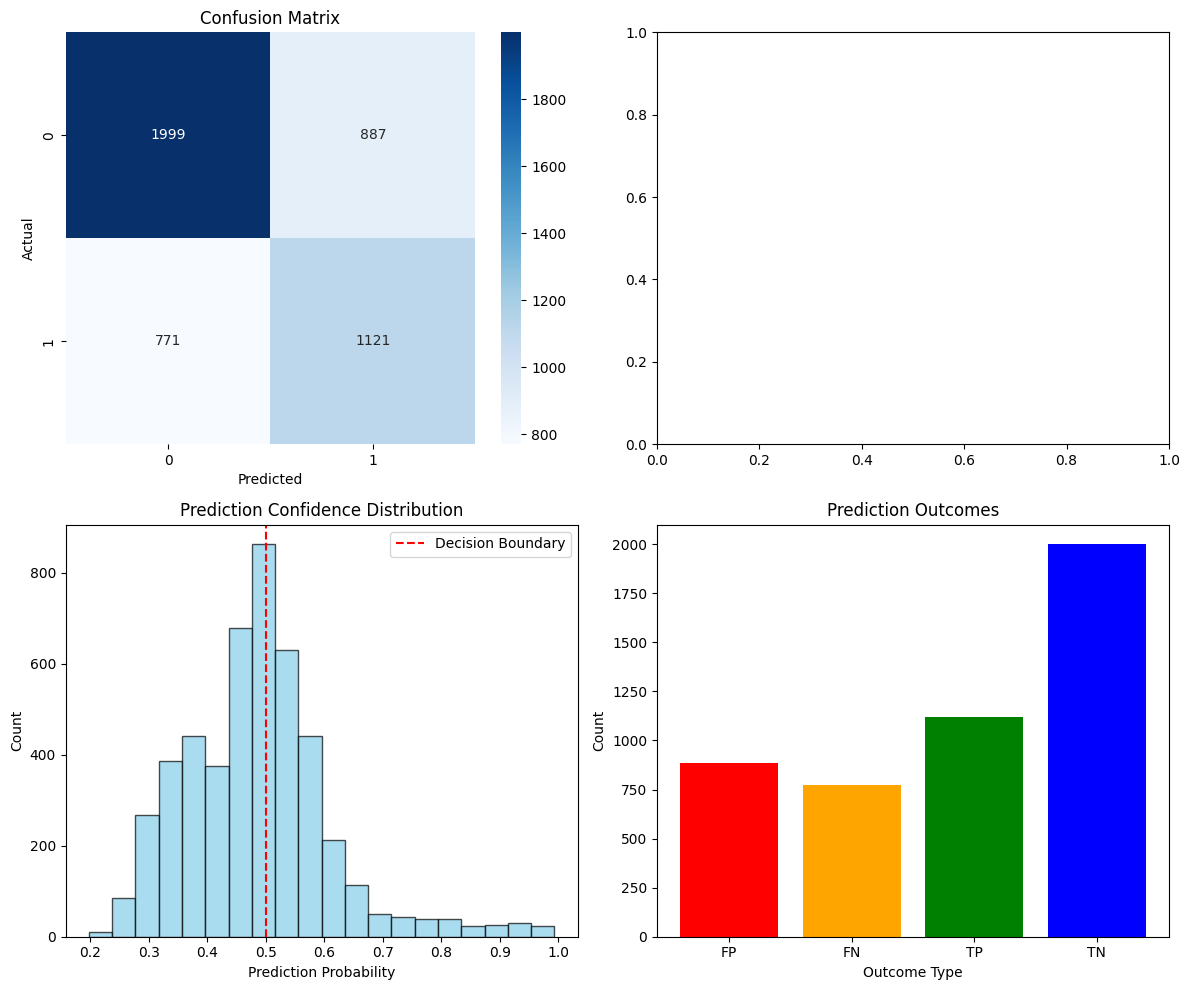

Optimal threshold analysis:
Current threshold: 0.487
Optimal threshold: 0.470


IndexError: index 0 is out of bounds for axis 0 with size 0

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def comprehensive_error_analysis(X_test, y_test, y_pred, y_pred_proba=None, 
                                 original_df=None, customer_id_col='numero_compte'):
    """
    Comprehensive error analysis after model retraining
    """
    print("=" * 80)
    print("COMPREHENSIVE ERROR ANALYSIS")
    print("=" * 80)
    
    results = {}
    
    # ========== 1. BASIC ERROR METRICS ==========
    print("\n📊 1. BASIC ERROR METRICS")
    print("-" * 60)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    print(f"Confusion Matrix:")
    print(f"  True Negatives:  {tn:>6} (Correctly rejected)")
    print(f"  False Positives: {fp:>6} (Predicted YES, actual NO) ← WASTED EFFORT")
    print(f"  False Negatives: {fn:>6} (Predicted NO, actual YES) ← MISSED OPPORTUNITIES")
    print(f"  True Positives:  {tp:>6} (Correctly predicted)")
    
    # Error rates
    total = len(y_test)
    fp_rate = fp / total * 100
    fn_rate = fn / total * 100
    error_rate = (fp + fn) / total * 100
    
    print(f"\nError Analysis:")
    print(f"  • Total errors: {fp + fn:,} ({error_rate:.1f}% of predictions)")
    print(f"  • False Positive rate: {fp_rate:.1f}% (wasted sales effort)")
    print(f"  • False Negative rate: {fn_rate:.1f}% (missed conversions)")
    
    results['confusion_matrix'] = cm
    results['error_rates'] = {'fp_rate': fp_rate, 'fn_rate': fn_rate, 'total_error': error_rate}
    
    # ========== 2. CONFIDENCE ANALYSIS ==========
    if y_pred_proba is not None:
        print(f"\n📈 2. PREDICTION CONFIDENCE ANALYSIS")
        print("-" * 60)
        
        # Create confidence bins
        confidence_bins = pd.cut(y_pred_proba, bins=[0, 0.3, 0.4, 0.6, 0.7, 1.0], 
                                labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
        
        # Analyze accuracy by confidence level
        confidence_df = pd.DataFrame({
            'actual': y_test,
            'predicted': y_pred,
            'probability': y_pred_proba,
            'confidence_level': confidence_bins
        })
        
        accuracy_by_confidence = confidence_df.groupby('confidence_level').apply(
            lambda x: (x['actual'] == x['predicted']).mean() * 100
        )
        
        print("Accuracy by Confidence Level:")
        for level, accuracy in accuracy_by_confidence.items():
            count = (confidence_df['confidence_level'] == level).sum()
            print(f"  • {level:10} confidence: {accuracy:.1f}% accurate ({count:,} predictions)")
        
        # Identify low-confidence predictions (need human review)
        low_confidence_mask = (y_pred_proba >= 0.4) & (y_pred_proba <= 0.6)
        low_confidence_count = low_confidence_mask.sum()
        
        print(f"\n⚠️  Low Confidence Predictions (40-60%):")
        print(f"  • Count: {low_confidence_count:,} ({low_confidence_count/len(y_test)*100:.1f}% of predictions)")
        print(f"  • These need human review or better features")
        
        results['confidence_analysis'] = confidence_df
        results['low_confidence_count'] = low_confidence_count
    
    # ========== 3. FEATURE IMPORTANCE IN ERRORS ==========
    print(f"\n🔍 3. FEATURE ANALYSIS OF ERRORS")
    print("-" * 60)
    
    if isinstance(X_test, pd.DataFrame):
        # Combine predictions with features
        error_df = X_test.copy()
        error_df['actual'] = y_test.values if hasattr(y_test, 'values') else y_test
        error_df['predicted'] = y_pred
        error_df['is_error'] = (y_test != y_pred).astype(int)
        error_df['error_type'] = np.select(
            [
                (y_test == 0) & (y_pred == 1),  # False Positive
                (y_test == 1) & (y_pred == 0),  # False Negative
                (y_test == y_pred) & (y_test == 1),  # True Positive
                (y_test == y_pred) & (y_test == 0)   # True Negative
            ],
            ['FP', 'FN', 'TP', 'TN'],
            default='Unknown'
        )
        
        # Analyze feature distributions for each error type
        numeric_features = error_df.select_dtypes(include=[np.number]).columns.tolist()
        
        print("Feature Value Differences by Error Type (mean values):")
        
        # Select key features based on your analysis
        key_features = [
            'total_quotes', 'avg_days_between_quotes', 'engagement_density',
            'solution_complexity_score', 'equipment_variety_count',
            'brand_loyalty_index', 'process_customer_fit', 'consideration_depth_score'
        ]
        
        # Filter to features that exist
        available_features = [f for f in key_features if f in error_df.columns]
        
        if available_features:
            error_stats = error_df.groupby('error_type')[available_features].mean()
            print(error_stats.round(3).to_string())
            
            results['error_feature_stats'] = error_stats
            
            # Identify features with biggest differences
            print(f"\n📊 Key Feature Differences:")
            
            for feature in available_features[:5]:  # Top 5 features
                fp_mean = error_stats.loc['FP', feature] if 'FP' in error_stats.index else np.nan
                fn_mean = error_stats.loc['FN', feature] if 'FN' in error_stats.index else np.nan
                tp_mean = error_stats.loc['TP', feature] if 'TP' in error_stats.index else np.nan
                
                if not np.isnan(fp_mean) and not np.isnan(tp_mean):
                    fp_vs_tp_diff = fp_mean - tp_mean
                    print(f"  • {feature:30}: FP are {fp_vs_tp_diff:+.3f} vs TP")
                
                if not np.isnan(fn_mean) and not np.isnan(tp_mean):
                    fn_vs_tp_diff = fn_mean - tp_mean
                    print(f"  • {feature:30}: FN are {fn_vs_tp_diff:+.3f} vs TP")
    
    # ========== 4. SEGMENT-SPECIFIC ERROR ANALYSIS ==========
    print(f"\n🎯 4. ERROR ANALYSIS BY CUSTOMER SEGMENT")
    print("-" * 60)
    
    if original_df is not None and customer_id_col in original_df.columns:
        # Merge with original data for segment analysis
        if 'statut_client' in original_df.columns:
            segment_errors = pd.DataFrame({
                'customer_id': original_df[customer_id_col],
                'segment': original_df['statut_client'],
                'actual': y_test,
                'predicted': y_pred,
                'is_error': (y_test != y_pred).astype(int)
            })
            
            # Error rates by segment
            segment_error_rates = segment_errors.groupby('segment').agg(
                total_customers=('customer_id', 'count'),
                error_count=('is_error', 'sum'),
                fp_count=('is_error', lambda x: ((segment_errors.loc[x.index, 'actual'] == 0) & 
                                                (segment_errors.loc[x.index, 'predicted'] == 1)).sum()),
                fn_count=('is_error', lambda x: ((segment_errors.loc[x.index, 'actual'] == 1) & 
                                                (segment_errors.loc[x.index, 'predicted'] == 0)).sum())
            )
            
            segment_error_rates['error_rate'] = segment_error_rates['error_count'] / segment_error_rates['total_customers'] * 100
            segment_error_rates['fp_rate'] = segment_error_rates['fp_count'] / segment_error_rates['total_customers'] * 100
            segment_error_rates['fn_rate'] = segment_error_rates['fn_count'] / segment_error_rates['total_customers'] * 100
            
            print("Error Rates by Customer Segment:")
            print(segment_error_rates[['total_customers', 'error_rate', 'fp_rate', 'fn_rate']].round(1).to_string())
            
            results['segment_error_analysis'] = segment_error_rates
            
            # Identify worst-performing segment
            worst_segment = segment_error_rates['error_rate'].idxmax()
            worst_error_rate = segment_error_rates['error_rate'].max()
            
            print(f"\n⚠️  WORST PERFORMING SEGMENT:")
            print(f"  • {worst_segment}: {worst_error_rate:.1f}% error rate")
            print(f"  • Needs feature improvement or separate modeling")
    
    # ========== 5. PATTERN ANALYSIS OF FALSE NEGATIVES ==========
    print(f"\n💡 5. FALSE NEGATIVE ANALYSIS (MISSED OPPORTUNITIES)")
    print("-" * 60)
    
    if 'error_type' in locals() and 'FN' in error_df['error_type'].values:
        fn_df = error_df[error_df['error_type'] == 'FN']
        
        if len(fn_df) > 0:
            print(f"Analyzing {len(fn_df):,} missed opportunities:")
            
            # Common patterns in false negatives
            patterns = []
            
            # Pattern 1: High consideration but predicted low
            if 'consideration_depth_score' in fn_df.columns:
                high_consideration_fn = (fn_df['consideration_depth_score'] > 0.6).sum()
                patterns.append(f"• {high_consideration_fn:,} had high consideration depth (>0.6)")
            
            # Pattern 2: Wrong process used
            if 'process_customer_fit' in fn_df.columns:
                poor_process_fit_fn = (fn_df['process_customer_fit'] < 0.4).sum()
                patterns.append(f"• {poor_process_fit_fn:,} had poor process fit (<0.4)")
            
            # Pattern 3: Multi-quote customers
            if 'total_quotes' in fn_df.columns:
                multi_quote_fn = (fn_df['total_quotes'] > 1).sum()
                patterns.append(f"• {multi_quote_fn:,} were multi-quote customers")
            
            # Pattern 4: Specific equipment types
            if 'regroup_famille_equipement_produit' in fn_df.columns:
                top_equipment_fn = fn_df['regroup_famille_equipement_produit'].value_counts().head(3)
                patterns.append(f"• Top equipment in FNs: {', '.join(top_equipment_fn.index.tolist())}")
            
            for pattern in patterns:
                print(f"  {pattern}")
            
            results['fn_patterns'] = patterns
    
    # ========== 6. RECOMMENDATIONS ==========
    print(f"\n🎯 6. ACTIONABLE RECOMMENDATIONS")
    print("=" * 60)
    
    recommendations = []
    
    # Based on error analysis
    if fp_rate > fn_rate:
        recommendations.append("Model is TOO AGGRESSIVE (too many False Positives)")
        recommendations.append("→ Increase prediction threshold")
        recommendations.append("→ Add features to identify 'tire-kickers'")
    else:
        recommendations.append("Model is TOO CONSERVATIVE (too many False Negatives)")
        recommendations.append("→ Decrease prediction threshold")
        recommendations.append("→ Improve features for high-potential customers")
    
    if 'low_confidence_count' in results and results['low_confidence_count'] > 0.1 * len(y_test):
        recommendations.append(f"Too many uncertain predictions ({results['low_confidence_count']/len(y_test)*100:.1f}%)")
        recommendations.append("→ Need better features for edge cases")
        recommendations.append("→ Consider human review for 40-60% confidence range")
    
    if 'worst_segment' in locals():
        recommendations.append(f"Segment '{worst_segment}' has highest error rate")
        recommendations.append(f"→ Create segment-specific features")
        recommendations.append(f"→ Consider separate model for this segment")
    
    for i, rec in enumerate(recommendations, 1):
        print(f"{i:2d}. {rec}")
    
    return results

# ========== ADDITIONAL ANALYSIS TOOLS ==========

def analyze_feature_contribution_to_errors(model, X_test, y_test, y_pred):
    """
    Analyze which features contribute most to errors
    """
    print("\n🔬 FEATURE CONTRIBUTION TO ERRORS")
    print("-" * 60)
    
    # Get feature importance if available
    if hasattr(model, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'feature': X_test.columns,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print("Top 10 Most Important Features:")
        print(feature_importance.head(10).to_string(index=False))
    
    # Analyze SHAP values if available
    try:
        import shap
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)
        
        # Analyze SHAP for errors
        error_mask = (y_test != y_pred)
        if error_mask.any():
            print("\nSHAP Analysis for Errors:")
            error_shap = shap_values[error_mask]
            error_features = X_test.columns[np.abs(error_shap).mean(axis=0).argsort()[-5:][::-1]]
            
            print("Features with largest SHAP impact on errors:")
            for feat in error_features:
                print(f"  • {feat}")
    
    except ImportError:
        print("SHAP not available for detailed error analysis")
    except:
        print("Could not compute SHAP values")

def create_error_visualization(results, y_test, y_pred, y_pred_proba=None):
    """
    Create visualizations of error patterns
    """
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 1. Confusion matrix heatmap
    cm = results['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
    axes[0, 0].set_title('Confusion Matrix')
    axes[0, 0].set_xlabel('Predicted')
    axes[0, 0].set_ylabel('Actual')
    
    # 2. Error rates by segment (if available)
    if 'segment_error_analysis' in results:
        segment_data = results['segment_error_analysis']
        segment_data['error_rate'].plot(kind='bar', ax=axes[0, 1], color='coral')
        axes[0, 1].set_title('Error Rate by Customer Segment')
        axes[0, 1].set_xlabel('Segment')
        axes[0, 1].set_ylabel('Error Rate (%)')
        axes[0, 1].tick_params(axis='x', rotation=45)
    
    # 3. Prediction confidence distribution
    if y_pred_proba is not None:
        axes[1, 0].hist(y_pred_proba, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        axes[1, 0].axvline(x=0.5, color='red', linestyle='--', label='Decision Boundary')
        axes[1, 0].set_title('Prediction Confidence Distribution')
        axes[1, 0].set_xlabel('Prediction Probability')
        axes[1, 0].set_ylabel('Count')
        axes[1, 0].legend()
    
    # 4. Error type comparison
    error_types = ['FP', 'FN', 'TP', 'TN']
    error_counts = [
        ((y_test == 0) & (y_pred == 1)).sum(),
        ((y_test == 1) & (y_pred == 0)).sum(),
        ((y_test == 1) & (y_pred == 1)).sum(),
        ((y_test == 0) & (y_pred == 0)).sum()
    ]
    
    colors = ['red', 'orange', 'green', 'blue']
    axes[1, 1].bar(error_types, error_counts, color=colors)
    axes[1, 1].set_title('Prediction Outcomes')
    axes[1, 1].set_xlabel('Outcome Type')
    axes[1, 1].set_ylabel('Count')
    
    plt.tight_layout()
    plt.show()



# ========== MAIN EXECUTION ==========
if __name__ == "__main__":
    X_test = __result['X_test']
    y_test = __result['y_test']
    model = __result['model']
    y_pred = model.predict(X_test)

    
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    comprehensive_error_analysis(X_test, y_test, y_pred, y_pred_proba)

    # 3. Run comprehensive error analysis
    error_results = comprehensive_error_analysis(
        X_test=X_test,
        y_test=y_test,
        y_pred=y_pred,
        y_pred_proba=y_pred_proba,
        original_df=X_new_clean,  # For segment analysis
        customer_id_col='numero_compte'
    )
    
    # 4. Additional analysis
    analyze_feature_contribution_to_errors(model, X_test, y_test, y_pred)
    
    # 5. Visualize errors
    create_error_visualization(error_results, y_test, y_pred, y_pred_proba)


def find_optimal_threshold(y_true, y_pred_proba, cost_fp=1, cost_fn=2):
    """
    Find optimal threshold considering business costs
    cost_fp: Cost of false positive (wasted sales time)
    cost_fn: Cost of false negative (missed conversion)
    """
    from sklearn.metrics import confusion_matrix
    
    thresholds = np.arange(0.30, 0.55, 0.01)
    results = []
    
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        
        # Calculate total cost
        total_cost = (fp * cost_fp) + (fn * cost_fn)
        
        # Calculate metrics
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        fn_rate = fn / (fn + tp)  # Miss rate among actual positives
        fp_rate = fp / (fp + tn)  # False alarm rate among actual negatives
        
        results.append({
            'threshold': threshold,
            'total_cost': total_cost,
            'accuracy': accuracy,
            'fn_rate': fn_rate,
            'fp_rate': fp_rate,
            'fn_count': fn,
            'fp_count': fp,
            'tp_count': tp,
            'tn_count': tn
        })
    
    results_df = pd.DataFrame(results)
    
    # Find minimum cost threshold
    optimal_row = results_df.loc[results_df['total_cost'].idxmin()]
    
    print("Optimal threshold analysis:")
    print(f"Current threshold: 0.487")
    print(f"Optimal threshold: {optimal_row['threshold']:.3f}")
    print(f"Expected reduction in total cost: {results_df.loc[results_df['threshold'] == 0.487, 'total_cost'].values[0] - optimal_row['total_cost']:.0f}")
    
    # Show trade-off
    print(f"\nTrade-off at optimal threshold {optimal_row['threshold']:.3f}:")
    print(f"  • False Negatives: {optimal_row['fn_count']} (missed opportunities)")
    print(f"  • False Positives: {optimal_row['fp_count']} (wasted effort)")
    print(f"  • Accuracy: {optimal_row['accuracy']:.3f}")
    
    return results_df, optimal_row

# Run this analysis
threshold_analysis, optimal = find_optimal_threshold(y_test, y_pred_proba)